In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial import cKDTree
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split


In [2]:
event_df = gpd.read_file("event_df_middelhav.shp")
df_monthly = pd.read_csv("df_summary_monthly_middelhav.csv")


In [5]:
df_monthly.columns

Index(['id', 'month', 'temperature_mean', 'temperature_median',
       'temperature_q25', 'temperature_q75', 'wind_speed_mean',
       'wind_speed_median', 'wind_speed_q25', 'wind_speed_q75',
       'drought20_mean', 'drought20_median', 'drought20_q25', 'drought20_q75',
       'humidity_mean', 'humidity_median', 'humidity_q25', 'humidity_q75'],
      dtype='object')

In [7]:
event_df.columns

Index(['id', 'start_dt', 'stop_dt', 'fire_occur', 'start_time', 'stop_time',
       'stop_date', 'sin_month', 'cos_month', 'temperatur', 'wind_speed',
       'drought_20', 'humidity', 'index', 'mean_elev', 'north', 'east', 'west',
       'slope30', 'road_den', 'pline_den', 'urban', 'forest', 'agricultur',
       'irrigated', 'shrubland', 'grassland', 'other', 'south', 'geometry'],
      dtype='object')

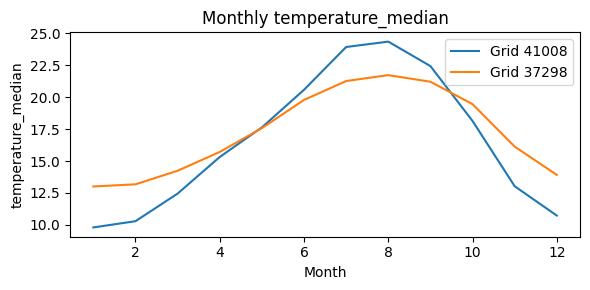

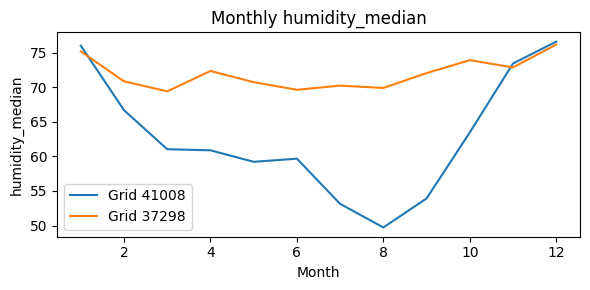

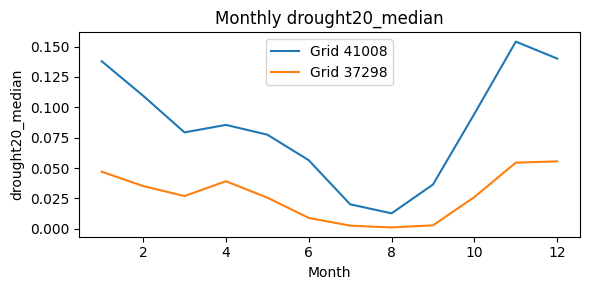

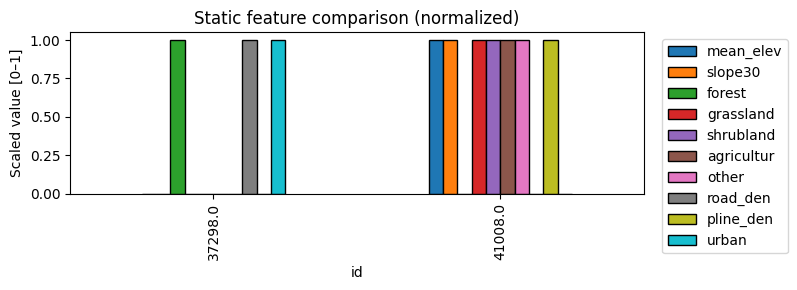

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# time-varying features from df_summary 
cells = [41008, 37298]
df_tv = df_monthly[df_monthly['id'].isin(cells)].copy()

# pivot so each cell is a line
for var in ['temperature_median','humidity_median','drought20_median']:
    plt.figure(figsize=(6,3))
    for cell in cells:
        subset = df_tv[df_tv['id']==cell]
        plt.plot(subset['month'], subset[var], label=f'Grid {cell}')
    plt.title(f'Monthly {var}')
    plt.xlabel('Month')
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()


# static landscape features from event_df 
df_stat = (
    event_df[event_df['id'].isin(cells)]
      .drop_duplicates('id')
      .set_index('id')[static_vars]
)

# scale to [0,1]
scaler = MinMaxScaler()
df_stat_scaled = pd.DataFrame(
    scaler.fit_transform(df_stat),
    index=df_stat.index,
    columns=df_stat.columns
)

# plot
ax = df_stat_scaled.plot(
    kind='bar',
    figsize=(8,3),
    edgecolor='k'
)
ax.set_ylabel("Scaled value [0–1]")
ax.set_title("Static feature comparison (normalized)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
event_df = event_df.sort_values(["id", "start_time"]).copy()

def fix_no_prior_fire(group):
    """
    For each grid (group), the first row is set to no_prior_fire=1.
    If we have already seen a fire in earlier rows, then no_prior_fire=0 for subsequent rows.
    """
    has_seen_fire = False
    for i in group.index:
        if i == group.index[0]:
            # first row in this grid
            group.loc[i, "no_prior_fire"] = 1
        else:
            # subsequent rows
            group.loc[i, "no_prior_fire"] = 0 if has_seen_fire else 1

        # If this row has a fire, update flag
        if group.loc[i, "fire_occur"] == 1:
            has_seen_fire = True
    return group


event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)

# reset index
event_df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

C:\Users\hclt0\AppData\Local\Temp\ipykernel_7068\3054020803.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [ ]:
# dataFrame is sorted by id time
event_df = event_df.sort_values(['id', 'start_time'])

# previous stop_time per id
event_df['prev_stop_time'] = (
    event_df
    .groupby('id')['stop_time']
    .shift(1)
)

# define start_time: 
#
event_df['true_start_time'] = event_df['prev_stop_time'].fillna(event_df['start_time'])

# recompute duration
event_df['duration'] = event_df['stop_time'] - event_df['true_start_time']

#    rename the columns 
event_df = event_df.rename(columns={
    'start_time': 'raw_start_time',
    'true_start_time': 'start_time'
})

print(event_df[["id", "start_time", "stop_time", "fire_occur"]].head(20))

         id  start_time  stop_time  fire_occur
0   37297.0         0.0        178           0
1   37297.0       178.0       4585           0
2   37297.0      4585.0       5843           0
3   37298.0         0.0        381           0
4   37298.0       381.0       3932           1
5   37298.0      3932.0       5263           0
6   37298.0      5263.0       5685           1
7   37298.0      5685.0       5843           0
8   37299.0         0.0        742           0
9   37299.0       742.0       3932           1
10  37299.0      3932.0       4753           0
11  37299.0      4753.0       5685           1
12  37299.0      5685.0       5843           0
13  37317.0         0.0       1497           0
14  37317.0      1497.0       1583           0
15  37317.0      1583.0       5843           0
16  37318.0         0.0       2409           0
17  37318.0      2409.0       2443           0
18  37318.0      2443.0       5843           0
19  37511.0         0.0        502           0


In [ ]:
def compute_days_since_fire(group):
    group = group.sort_values("start_dt").copy()
    last_fire_stop = None
    days_list = []

    for _, row in group.iterrows():
        if last_fire_stop is None:
            # First event: days is 1 if no prior fire, else 0
            days = 1 if row["no_prior_fire"] == 1 else 0
        else:
            # For both fire and non-fire events, use stop_dt to compute days
            days = (row["stop_dt"] - last_fire_stop).days

        days_list.append(days)

        # Update last_fire_stop only if the current row is a fire
        if row["fire_occur"] == 1:
            last_fire_stop = row["stop_dt"]

    group["days_since_last_fire"] = days_list
    return group

# Apply function
df = (
    event_df.sort_values(["id", "start_dt"])
    .groupby("id", group_keys=False)
    .apply(compute_days_since_fire)
    .reset_index(drop=True)
)

# no_prior_fire stays the same
no_fire_map = df.groupby("id")["fire_occur"].max().apply(lambda x: 0 if x==1 else 1)
df["no_prior_fire"] = df["id"].map(no_fire_map)

event_df = df

event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)
event_df["days_since_last_fire"] = event_df["days_since_last_fire"].replace(0, 1)
print(event_df[[
    "id", "stop_time", "fire_occur",
    "days_since_last_fire", "no_prior_fire"
]].head(30))

C:\Users\hclt0\AppData\Local\Temp\ipykernel_7068\3590277647.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df.sort_values(["id", "start_dt"])


         id  stop_time  fire_occur  days_since_last_fire  no_prior_fire
0   37297.0        178           0                     1              1
1   37297.0       4585           0                     1              1
2   37297.0       5843           0                     1              1
3   37298.0        381           0                     1              1
4   37298.0       3932           1                     1              1
5   37298.0       5263           0                  1331              0
6   37298.0       5685           1                  1753              0
7   37298.0       5843           0                   158              0
8   37299.0        742           0                     1              1
9   37299.0       3932           1                     1              1
10  37299.0       4753           0                   821              0
11  37299.0       5685           1                  1753              0
12  37299.0       5843           0                   158        

C:\Users\hclt0\AppData\Local\Temp\ipykernel_7068\3590277647.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_df = event_df.groupby("id", group_keys=False).apply(fix_no_prior_fire)


In [ ]:
no_fire_ids = (
    event_df
    .groupby("id")["fire_occur"]
    .sum()
    .loc[lambda s: s == 0]
    .index
)

df_nf = event_df[event_df["id"].isin(no_fire_ids)].copy()

# squash the first interval of any 3 row group
def squash_first(group):
    group = group.sort_values("start_time").reset_index(drop=True)
    if len(group) == 3:
        first = group.loc[0]
        second = group.loc[1].copy()
        third = group.loc[2]
        # move the second interval to start where the first one did
        second["start_time"] = first["start_time"]
        return pd.DataFrame([second, third])
    return group

df_nf_trimmed = (
    df_nf
    .groupby("id", group_keys=False)
    .apply(squash_first)
    .reset_index(drop=True)
)

# recompute duration
df_nf_trimmed["duration"] = (
    df_nf_trimmed["stop_time"] - df_nf_trimmed["start_time"]
)

# put the firegrids and the trimmed nofire grids back together
df_fire = event_df[~event_df["id"].isin(no_fire_ids)].copy()
event_df_cleaned = pd.concat([df_fire, df_nf_trimmed], ignore_index=True)\
    .sort_values(["id", "start_time"])\
    .reset_index(drop=True)


df = event_df_cleaned.copy().reset_index(drop=False).rename(columns={"index":"unique_idx"})

# full‑span non‑fire intervals
mask_full = (
    (df["days_since_last_fire"] == df["duration"])
  & (df["fire_occur"] == 0)
)

# randomly pick % 
to_squash_idxs = (
    df.loc[mask_full, "unique_idx"]
      .sample(frac=0.2, random_state=42)
      .tolist()
)

df["to_squash"] = df["unique_idx"].isin(to_squash_idxs)

# define a group‐wise squash that only acts on flagged rows
def squash_flagged(group):
    g = group.sort_values("start_time").reset_index(drop=True)
    out = []
    i = 0
    while i < len(g):
        if g.loc[i, "to_squash"] and (i+1) < len(g):
            # merge this interval into the next one
            nxt = g.loc[i+1].copy()
            nxt["start_time"] = g.loc[i, "start_time"]
            out.append(nxt)
            i += 2   # skip both rows
        else:
            out.append(g.loc[i])
            i += 1
    return pd.DataFrame(out)

# apply per-grid and recompute duration
df_reduced = (
    df
    .groupby("id", group_keys=False)
    .apply(squash_flagged)
    .reset_index(drop=True)
)
df_reduced["duration"] = df_reduced["stop_time"] - df_reduced["start_time"]

# see the effect
mask2 = (
    (df_reduced["days_since_last_fire"] == df_reduced["duration"])
  & (df_reduced["fire_occur"] == 0)
)
print("Remaining full-span non-fires:", mask2.sum())
print("Original count was:", mask_full.sum())


# print(df_squashed[["id", "start_time", "stop_time", "fire_occur", "duration"]].head(20))

C:\Users\hclt0\AppData\Local\Temp\ipykernel_7068\482817152.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_nf


Remaining full‑span non‑fires: 6574
Original count was: 19349


C:\Users\hclt0\AppData\Local\Temp\ipykernel_7068\482817152.py:79: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [ ]:


# build the mask
leak_mask = df_reduced["days_since_last_fire"] == df_reduced['duration']

# total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == duration: {n_leak}")

# breakdown of fire_occurred_x in those rows
vc = df_reduced.loc[leak_mask, "fire_occur"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)
leak_mask = df_reduced["days_since_last_fire"] == 1

#total number of “leaky” rows
n_leak = leak_mask.sum()
print(f"Number of rows where days_since_last_fire == 1: {n_leak}")

# breakdown of fire_occurred_x in those rows
vc = df_reduced.loc[leak_mask, "fire_occur"].value_counts().sort_index()
print("fire_occurred_x value counts among those rows:")
print(vc)



Number of rows where days_since_last_fire == duration: 15315
fire_occurred_x value counts among those rows:
fire_occur
0    6574
1    8741
Name: count, dtype: int64
Number of rows where days_since_last_fire == 1: 33592
fire_occurred_x value counts among those rows:
fire_occur
0    28169
1     5423
Name: count, dtype: int64


In [ ]:
df_reduced["sample_weight"] = np.where(
    df_reduced["days_since_last_fire"] == 1,
    0.5,   # fraction  to down‑weight
    1.0
)
event_df = df_reduced

In [14]:
df_monthly

,id,month,temperature_mean,temperature_median,temperature_q25,temperature_q75,wind_speed_mean,wind_speed_median,wind_speed_q25,wind_speed_q75,drought20_mean,drought20_median,drought20_q25,drought20_q75,humidity_mean,humidity_median,humidity_q25,humidity_q75
0,37297.0,1,12.849747,13.010180,12.012064,13.878440,21.303571,20.245604,12.451298,29.391254,0.052375,0.046972,0.018056,0.071479,74.675885,75.200705,65.858780,84.316459
1,37297.0,2,13.070123,13.180176,12.234821,14.166833,21.614152,20.568410,13.338795,28.971600,0.045376,0.035137,0.013304,0.066219,70.801673,70.869240,62.477393,80.016201
2,37297.0,3,14.325687,14.244023,13.297712,15.305005,20.599359,19.325250,12.893608,27.734143,0.043815,0.026919,0.012081,0.062551,68.830692,69.419427,60.355102,77.723177
3,37297.0,4,15.797421,15.716141,14.415526,16.968241,19.846360,18.613892,13.300791,25.360986,0.043704,0.039115,0.019521,0.061114,70.889559,72.366830,64.332927,78.441137
4,37297.0,5,17.790405,17.581763,16.509413,19.246019,20.122731,19.529777,13.606617,26.609033,0.032056,0.025586,0.012965,0.049293,69.235497,70.748343,63.451713,76.568033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209047,110367.0,8,29.264376,29.155077,28.620368,29.843585,20.178240,20.268384,13.005985,27.441588,0.000189,0.000019,0.000015,0.000032,67.636146,68.395840,64.806176,71.504275
209048,110367.0,9,27.350267,27.499693,26.600377,28.404913,21.459102,21.070227,14.371800,28.331808,0.006603,0.000070,0.000020,0.002051,63.528819,64.479058,59.293334,68.911693
209049,110367.0,10,23.703277,23.800199,22.506798,24.936672,18.067634,17.543451,9.756533,24.977539,0.023199,0.013499,0.002933,0.033402,64.737369,65.061783,59.240282,71.858722
209050,110367.0,11,20.151487,20.154014,18.978960,21.377471,17.727576,15.860987,8.398496,24.072321,0.057050,0.057562,0.025528,0.084834,65.458569,65.709268,57.193782,73.797152


In [ ]:
import pandas as pd

T0 = 4479

# sort by id, start_time so we always split in order
df = event_df.sort_values(["id", "start_time"]).reset_index(drop=True)

new_rows = []
for _, r in df.iterrows():
    start, stop, event, gid = r["start_time"], r["stop_time"], r["fire_occur"], r["id"]
    
    #  if crosses the cutoff
    if start < T0 < stop:
        # pre-cut piece (censored at T0)
        pre = r.to_dict()
        pre["stop_time"]   = T0
        pre["duration"]    = T0 - start
        pre["fire_occur"]  = 0
        new_rows.append(pre)
        
        # post-cut piece (starts at T0, keeps original event flag)
        post = r.to_dict()
        post["start_time"] = T0
        post["duration"]   = stop - T0
        # post["fire_occur"] remains the original 0/1
        new_rows.append(post)
    else:
        # no split needed
        new_rows.append(r.to_dict())

df_split = pd.DataFrame(new_rows)
mask_post = df_split["stop_time"] == T0

def refresh_covariates(row):
    vals = get_monthly_values(df_monthly, row["id"], day_to_month(T0 % 365), stat="median")
    row["temperatur"] = vals["temperatur"]
    row["drought20"]  = vals["drought_20"]
    row["wind_speed"] = vals["wind_speed"]
    row["humidity"]   = vals["humidity"]
    cos_m, sin_m = compute_seasonality_cos_sin(T0)
    row["cos_month"] = cos_m
    row["sin_month"] = sin_m
    return row

df_split.loc[mask_post] = df_split.loc[mask_post].apply(refresh_covariates, axis=1)

# only pre‐cut, non‐fire rows with at least one prior fire
mask_pre = (
    (df_split["stop_time"] == T0)
    & (df_split["fire_occur"] == 0)
    & (df_split["no_prior_fire"] == 0)
)

for idx in df_split[mask_pre].index:
    row = df_split.loc[idx]
    gid = row["id"]
    dur = row["duration"]

    # find the post‐cut piece: start_time == T0 for the same grid
    nxt = df_split[
        (df_split["id"] == gid)
        & (df_split["start_time"] == T0)
    ]
    if nxt.empty:
        continue

    next_dsf = nxt.iloc[0]["days_since_last_fire"]
    # subtract this truncated intervals duration
    df_split.at[idx, "days_since_last_fire"] = next_dsf - dur


In [ ]:
import numpy as np

# collect all integer‐rounded boundaries in window
lower, upper = 4000, 4500
candidates = np.arange(lower, upper + 1)

# Round your actual start/stop times to nearest integer
used = set(np.round(event_df["start_time"]).astype(int)) \
     | set(np.round(event_df["stop_time"]).astype(int))

# 2) Find which candidates are “free”
free = [t for t in candidates if t not in used]

if not free:
    raise ValueError(f"No free threshold found in [{lower},{upper}]")

# 3) Pick one—e.g. the middle of the free zone
T0 = free[len(free)//2]
print(f"Using temporal cutoff T0 = {T0}, which is free of existing boundaries.")



Using temporal cutoff T0 = 4479, which is free of existing boundaries.


In [87]:
print(df_split[['id','stop_time', 'duration','days_since_last_fire', 'fire_occur', 'no_prior_fire']].head(7))

        id  stop_time  duration  days_since_last_fire  fire_occur  \
0  37297.0       4479    4479.0                     1           0   
1  37297.0       4585     106.0                     1           0   
2  37297.0       5843    1258.0                     1           0   
3  37298.0       3932    3932.0                     1           1   
4  37298.0       4479     547.0                  1206           0   
5  37298.0       5685    1206.0                  1753           1   
6  37298.0       5843     158.0                   158           0   

   no_prior_fire  
0              1  
1              1  
2              1  
3              1  
4              0  
5              0  
6              0  


In [60]:
print(df_split[['id','start_time','stop_time', 'duration','days_since_last_fire', 'fire_occur']].head(7))

        id  start_time  stop_time  duration  days_since_last_fire  fire_occur
0  37297.0         0.0       4200    4200.0                     1           0
1  37297.0      4200.0       4585     385.0                     1           0
2  37297.0      4585.0       5843    1258.0                     1           0
3  37298.0         0.0       3932    3932.0                     1           1
4  37298.0      3932.0       4200     268.0                  1753           0
5  37298.0      4200.0       5685    1485.0                  1753           1
6  37298.0      5685.0       5843     158.0                   158           0


In [57]:
print(event_df[['id','start_time','stop_time', 'duration','days_since_last_fire']].head(7))

        id  start_time  stop_time  duration  days_since_last_fire
0  37297.0         0.0       4585    4585.0                     1
1  37297.0      4585.0       5843    1258.0                     1
2  37298.0         0.0       3932    3932.0                     1
3  37298.0      3932.0       5685    1753.0                  1753
4  37298.0      5685.0       5843     158.0                   158
5  37299.0         0.0       3932    3932.0                     1
6  37299.0      3932.0       5685    1753.0                  1753


In [25]:
print(event_df[['id','start_time','stop_time']])

             id  start_time  stop_time
0       37297.0         0.0       4585
1       37297.0      4585.0       5843
2       37298.0         0.0       3932
3       37298.0      3932.0       5685
4       37298.0      5685.0       5843
...         ...         ...        ...
55800  110150.0      5224.0       5843
55801  110366.0         0.0       4369
55802  110366.0      4369.0       5843
55803  110367.0         0.0       3800
55804  110367.0      3800.0       5843

[55805 rows x 3 columns]


In [27]:
print(df_tr[['id','start_time','stop_time']])

             id  start_time  stop_time
2       37298.0         0.0       3932
5       37299.0         0.0       3932
8       37317.0         0.0       1583
10      37318.0         0.0       2443
18      37517.0         0.0        276
...         ...         ...        ...
55787  109932.0         0.0       3204
55791  110147.0         0.0       2791
55794  110148.0         0.0        981
55796  110149.0         0.0       3680
55803  110367.0         0.0       3800

[20772 rows x 3 columns]


In [103]:
event_df.columns

Index(['level_0', 'id', 'start_dt', 'stop_dt', 'fire_occur', 'raw_start_time',
       'stop_time', 'stop_date', 'sin_month', 'cos_month', 'temperatur',
       'wind_speed', 'drought_20', 'humidity', 'unique_idx', 'mean_elev',
       'north', 'east', 'west', 'slope30', 'road_den', 'pline_den', 'urban',
       'forest', 'agricultur', 'irrigated', 'shrubland', 'grassland', 'other',
       'south', 'geometry', 'no_prior_fire', 'prev_stop_time', 'start_time',
       'duration', 'days_since_last_fire', 'to_squash', 'sample_weight'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from lifelines import CoxPHFitter

# 
gdf = gpd.GeoDataFrame(df_split.copy(), geometry='geometry')
# compute centroids
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y

# ensure no zero-duration intervals
eps = 0.5
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps
# compute duration
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]

# TEMPORAL SPLIT
# train on first days, test on the rest
threshold_days = 4479
train_idx = gdf["stop_time"] <= threshold_days
test_idx  = gdf["stop_time"] > threshold_days

df_tr = gdf[train_idx].copy()
df_te = gdf[test_idx].copy()

# NEIGHBOR FEATURES (TRAIN only) 
coords_tr = df_tr[["centroid_x","centroid_y"]].values
tree = cKDTree(coords_tr)
R = 10000  # meters
lag_days = 10
nbr_cols = ["nbr_fire_risk","nbr_forest","nbr_road","nbr_powerline"]
# init
for df in (df_tr, df_te):
    for c in nbr_cols:
        df[c] = np.nan
# compute on TRAIN
for i, pt in enumerate(coords_tr):
    my_start = df_tr.iloc[i]["start_time"]
    all_nb = tree.query_ball_point(pt, R)
    past_nb = [j for j in all_nb if df_tr.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_tr.iloc[past_nb]
    dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_tr.at[df_tr.index[i], "nbr_fire_risk"]  = sub["fire_occur"].sum() / sub["duration"].sum()
    df_tr.at[df_tr.index[i], "nbr_forest"]     = np.average(sub["forest"], weights=w)
    df_tr.at[df_tr.index[i], "nbr_road"]       = np.average(sub["road_den"], weights=w)
    df_tr.at[df_tr.index[i], "nbr_powerline"]  = np.average(sub["pline_den"], weights=w)
# compute on TEST (only using TRAIN history)
coords_tr = df_tr[["centroid_x","centroid_y"]].values
for i, pt in enumerate(df_te[["centroid_x","centroid_y"]].values):
    my_start = df_te.iloc[i]["start_time"]
    all_nb = tree.query_ball_point(pt, R)
    past_nb = [j for j in all_nb if df_tr.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_tr.iloc[past_nb]
    dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_te.at[df_te.index[i], "nbr_fire_risk"]  = sub["fire_occur"].sum() / sub["duration"].sum()
    df_te.at[df_te.index[i], "nbr_forest"]     = np.average(sub["forest"], weights=w)
    df_te.at[df_te.index[i], "nbr_road"]       = np.average(sub["road_den"], weights=w)
    df_te.at[df_te.index[i], "nbr_powerline"]  = np.average(sub["pline_den"], weights=w)

# FILL MISSING NEIGHBOR FEATURES
# avoid chained assignment warnings
nbr_cols = ["nbr_forest","nbr_road","nbr_powerline"]
for df in [df_tr, df_te]:
    df[nbr_cols] = df[nbr_cols].fillna(df_tr[nbr_cols].median())
    df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)


# DERIVED FEATURES 
for df in (df_tr, df_te):
    df["forest_combined"] = (df["forest"] + df["nbr_forest"]) / 2
    df["temp_sq"] = df["temperatur"] ** 2

# fill any remaining NaNs in vegetation/landcover
fill_zero_cols = [
    "forest_combined",
    "agricultur",
    "shrubland",
    "grassland",
    "urban",
    "other",
    "irrigated"
]
for df in (df_tr, df_te):
    df[fill_zero_cols] = df[fill_zero_cols].fillna(0)

# SCALING 
to_scale = [
    "temperatur","drought_20","forest_combined",
    "days_since_last_fire","nbr_fire_risk","nbr_powerline","nbr_forest",
    "humidity","mean_elev","slope30","agricultur","shrubland",
    "grassland","urban","other","pline_den", "irrigated"
]
coords_train = df_tr[["centroid_x", "centroid_y"]].values
tree_train = cKDTree(coords_train)

df_tr_raw = df_tr.copy() 

scaler = MinMaxScaler()
df_tr[to_scale] = scaler.fit_transform(df_tr[to_scale])
df_te[to_scale] = scaler.transform(df_te[to_scale])

#  FIT & EVALUATE CoxPH 
features = [
    "temperatur","drought_20","forest_combined",
    "nbr_fire_risk","nbr_forest","nbr_powerline","cos_month","sin_month",
    "temp_sq","days_since_last_fire","mean_elev",
    "slope30","humidity","pline_den","agricultur","shrubland",
    "grassland","urban","other", "irrigated"
]

cph = CoxPHFitter(penalizer=0.01)
cph.fit(df_tr[features + ["duration","fire_occur","id"]], 
        duration_col="duration",  event_col="fire_occur", cluster_col="id")
model_package = {
    "model": cph,
    "scaler": scaler,
    "df_train_raw": df_tr_raw,  # unscaled
    "coords_train": coords_train,
    "tree_train": tree_train
    
}
ensemble_models = [model_package]
# concordance
print("Train C-index:", cph.score(df_tr[features + ["duration","fire_occur"]], "concordance_index"))
print("Test  C-index:", cph.score(df_te[features + ["duration","fire_occur"]], "concordance_index"))


Train C-index: 0.8963514080882357
Test  C-index: 0.8623638445471392


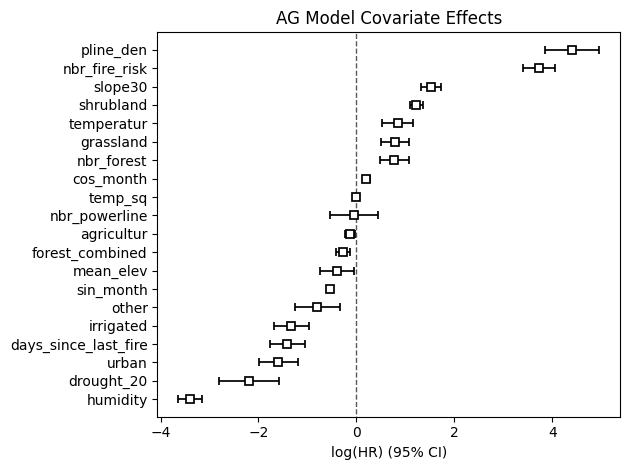

In [12]:
cph.plot()
plt.title("AG Model Covariate Effects")
plt.tight_layout()
plt.show()

In [19]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
temperatur,0.843486,2.324456,0.161329,0.527287,1.159685,1.694330,3.188927,0.0,5.228367,1.710135e-07,22.479387
drought_20,-2.196829,0.111155,0.311459,-2.807278,-1.586380,0.060369,0.204665,0.0,-7.053345,1.746675e-12,39.058526
forest_combined,-0.277398,0.757753,0.070238,-0.415063,-0.139733,0.660299,0.869590,0.0,-3.949372,7.835658e-05,13.639586
nbr_fire_risk,3.726459,41.531793,0.170448,3.392387,4.060532,29.736846,58.005138,0.0,21.862707,5.884912e-106,349.567357
nbr_forest,0.777062,2.175072,0.151598,0.479935,1.074189,1.615969,2.927618,0.0,5.125799,2.962790e-07,21.686540
nbr_powerline,-0.051251,0.950040,0.248440,-0.538185,0.435682,0.583807,1.546018,0.0,-0.206291,8.365633e-01,0.257453
cos_month,0.198077,1.219056,0.037439,0.124698,0.271456,1.132806,1.311873,0.0,5.290660,1.218758e-07,22.968085
sin_month,-0.532647,0.587049,0.029407,-0.590283,-0.475010,0.554170,0.621879,0.0,-18.112991,2.516956e-73,241.169071
temp_sq,0.000753,1.000753,0.000080,0.000596,0.000910,1.000596,1.000910,0.0,9.415320,4.716446e-21,67.522790


Integrated Brier Score: 0.1052
Integrated Brier Score: 0.1052 ± 0.0013


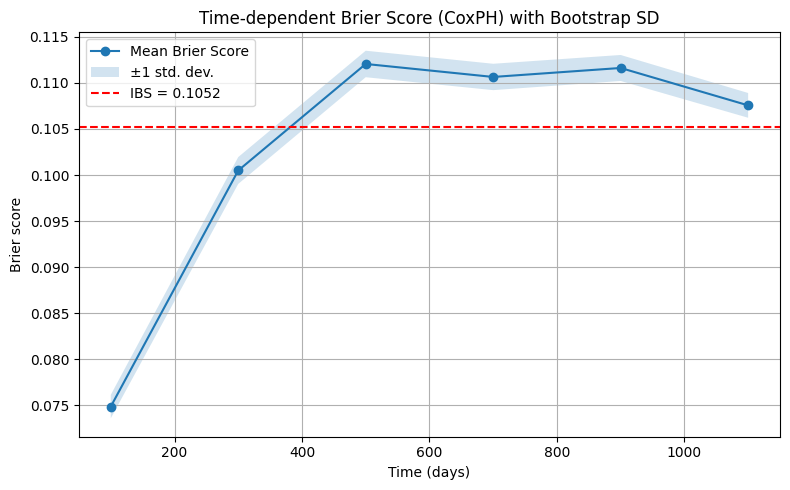

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from sksurv.util import Surv

#urvival arrays
y_train_struct = Surv.from_dataframe("fire_occur", "duration", df_tr)
y_test_full    = Surv.from_dataframe("fire_occur", "duration", df_te)

# evaluation times
eval_times = np.arange(100, 1300, 200)

# predict survival functions on the full test set
# sf_df has shape (n_times, n_samples)
sf_df    = cph.predict_survival_function(df_te[features], times=eval_times)
#    we want (n_samples, n_times)
sf_full = sf_df.values.T

# bootstrap Brier curves
n_bootstraps = 200
n_times      = len(eval_times)
n_test       = len(df_te)
all_bs       = np.zeros((n_bootstraps, n_times))
indices      = np.arange(n_test)

for b in range(n_bootstraps):
    # sample test‐set indices with replacement
    boot_idx = np.random.choice(indices, size=n_test, replace=True)
    # slice structured y_test and survival‐matrix
    y_test_b = y_test_full[boot_idx]     
    sf_b     = sf_full[boot_idx, :]      # shape (n_test, n_times)

    # compute Brier curve
    _, bs_curve = brier_score(
        y_train_struct,
        y_test_b,
        sf_b,
        eval_times
    )
    all_bs[b] = bs_curve

# aggregate
mean_bs = all_bs.mean(axis=0)
std_bs  = all_bs.std(axis=0)
ibs     = np.trapezoid(mean_bs, eval_times) / (eval_times[-1] - eval_times[0])

print(f"Integrated Brier Score: {ibs:.4f}")


# compute the IBS for each bootstrap replication
ibs_boot = np.array([
    np.trapezoid(bs_curve, eval_times) / (eval_times[-1] - eval_times[0])
    for bs_curve in all_bs
])

# compute mean and std of those IBS values
ibs_mean = ibs_boot.mean()
ibs_std  = ibs_boot.std(ddof=1)   

print(f"Integrated Brier Score: {ibs_mean:.4f} ± {ibs_std:.4f}")

# plot
plt.figure(figsize=(8,5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs, color="red", linestyle="--", label=f"IBS = {ibs:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier score")
plt.title("Time-dependent Brier Score (CoxPH) with Bootstrap SD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


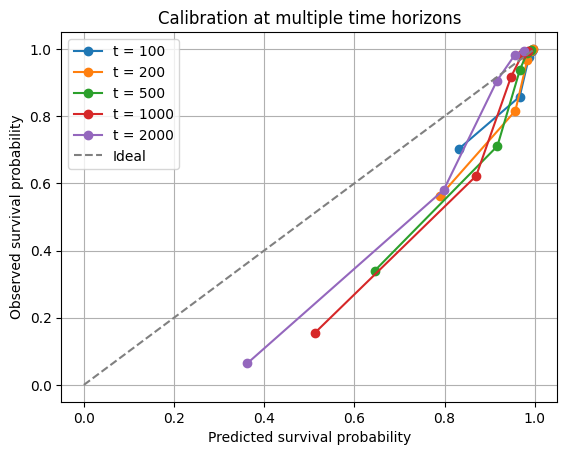

In [ ]:
from lifelines import KaplanMeierFitter

#  time horizon
time_horizons = [100, 200, 500, 1000, 2000]

n_bins = 5

calibration_data = []

for t in time_horizons:
    surv_df = cph.predict_survival_function(df_te[features], times=[t])
    pred_surv = surv_df.iloc[0].values
    
    df_te["pred_surv_prob"] = pred_surv
    df_te["risk_group"] = pd.qcut(pred_surv, q=n_bins, labels=False)
    
    group_pred, group_obs = [], []
    kmf = KaplanMeierFitter()
    
    for group in range(n_bins):
        sub = df_te[df_te["risk_group"] == group]
        group_pred.append(sub["pred_surv_prob"].mean())
        kmf.fit(sub["duration"], sub["fire_occur"])
        group_obs.append(kmf.predict(t))
    
    for gp, go in zip(group_pred, group_obs):
        calibration_data.append({"time": t, "pred": gp, "obs": go})

# convert dataFrame for plotting
df_cal = pd.DataFrame(calibration_data)

#  all together
fig, ax = plt.subplots()
for t in df_cal["time"].unique():
    sub = df_cal[df_cal["time"] == t]
    ax.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

ax.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
ax.set_xlabel("Predicted survival probability")
ax.set_ylabel("Observed survival probability")
ax.set_title("Calibration at multiple time horizons")
ax.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='log(HR) (95% CI)'>

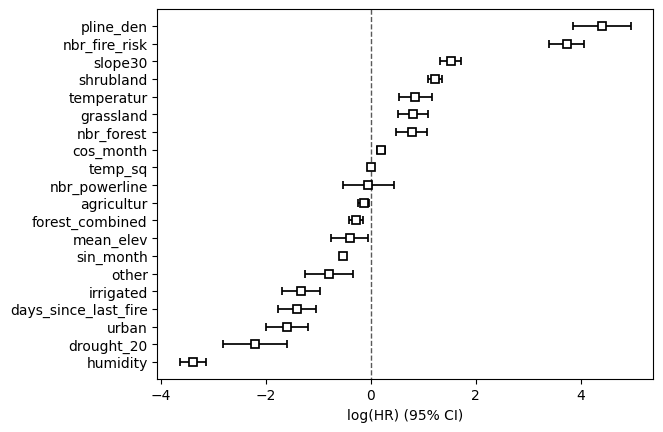

In [20]:
cph.plot()

In [21]:
cph.print_summary()

model,lifelines.CoxPHFitter
duration col,'duration'
event col,'fire_occur'
cluster col,'id'
penalizer,0.01
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,40420
number of events observed,9756
partial log-likelihood,-88581.99


In [ ]:
import numpy as np
import pandas as pd

def compute_seasonality_cos_sin(t_days):
    cos_month = np.cos(2 * np.pi * (t_days % 365) / 365)
    sin_month = np.sin(2 * np.pi * (t_days % 365) / 365)
    return cos_month, sin_month


def day_to_month(day):
    # assume 30-day months
    return min(12, int(day // 30) + 1)


def get_monthly_values(df_monthly, grid_id, month, stat='median'):
    """
    Retrieve monthly values for your model features:
      - temperatur    ← from temperature_{stat}
      - wind_speed    ← from wind_speed_{stat}
      - drought_20    ← from drought20_{stat}
      - humidity      ← from humidity_{stat}
    """
    suffix = f"_{stat}"
    # subset to the one row
    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    row = row.iloc[0]  # turn into a Series
    
    # pull out each, with a fallback if naming is slightly different
    temp_col = f"temperature{suffix}"
    wind_col = f"wind_speed{suffix}"
    drought_col = f"drought20{suffix}"
    humid_col = f"humidity{suffix}"
    
    return {
        "temperatur":   row[temp_col],
        "wind_speed":   row[wind_col],
        "drought_20":   row[drought_col],
        "humidity":     row[humid_col],
    }



def build_baseline_row(event_df, grid_id):
    subset = event_df[event_df["id"] == grid_id].copy()
    if subset.empty:
        raise ValueError(f"No data for grid_id={grid_id}")

    # ensure centroid and coordinates exist
    if "centroid_x" not in subset.columns or "centroid_y" not in subset.columns:
        if "centroid" not in subset.columns:
            subset["centroid"] = subset.geometry.centroid
        subset["centroid_x"] = subset["centroid"].x
        subset["centroid_y"] = subset["centroid"].y

    baseline = subset.median(numeric_only=True).to_dict()

    required_features = [
        "pline_den", "grassland", "shrubland", "agricultur", "forest", "road_den",
        "slope30", "mean_elev", "no_prior_fire", "centroid_x", "centroid_y",
        "urban", "other", "irrigated"
    ]
    for var in required_features:
        if var not in baseline or pd.isna(baseline[var]):
            non_null = subset[var].dropna()
            baseline[var] = non_null.iloc[0] if len(non_null) else 0.0

    return baseline




def compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius, lag_days=10):
    point = np.array([row["centroid_x"], row["centroid_y"]])
    my_stop = row["stop_time"]

    all_nb = tree_train.query_ball_point(point, neighbor_radius)
    # only keep neighbors with earlier stop_time
    past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (my_stop - lag_days)]

    if not past_nb:
        for col in ["nbr_fire_risk", "nbr_forest", "nbr_road", "nbr_powerline"]:
            row[col] = df_train[col].median()
        return row

    neighs = df_train.iloc[past_nb]
    dists  = np.linalg.norm(coords_train[past_nb] - point, axis=1) + 1e-6
    weights = 1.0 / dists

    row.update({
        "nbr_fire_risk":    neighs["fire_occur"].sum() / (neighs["duration"].sum() + 1e-9),
        "nbr_forest":       np.average(neighs["forest"], weights=weights),
        "nbr_road":         np.average(neighs["road_den"], weights=weights),
        "nbr_powerline":    np.average(neighs["pline_den"], weights=weights),
    })
    return row

def compute_static_neighbor_features(df_train, coords_train, tree_train, radius, lag_days=10):
    feature_dict = {}

    unique_grids = df_train[["id", "centroid_x", "centroid_y"]].drop_duplicates()
    for _, row in unique_grids.iterrows():
        grid_id = row["id"]
        pt = np.array([row["centroid_x"], row["centroid_y"]])
        all_nb = tree_train.query_ball_point(pt, radius)
        past_nb = [j for j in all_nb if df_train.iloc[j]["stop_time"] < (df_train["stop_time"].max() - lag_days)]

        if not past_nb:
            feature_dict[grid_id] = {
                "nbr_fire_risk": 0.0,
                "nbr_forest": 0.0,
                "nbr_road": 0.0,
                "nbr_powerline": 0.0
            }
            continue

        sub = df_train.iloc[past_nb]
        dists = np.linalg.norm(coords_train[past_nb] - pt, axis=1) + 1e-6
        weights = 1.0 / dists

        feature_dict[grid_id] = {
            "nbr_fire_risk": sub["fire_occur"].sum() / (sub["duration"].sum() + 1e-9),
            "nbr_forest": np.average(sub["forest"], weights=weights),
            "nbr_road": np.average(sub["road_den"], weights=weights),
            "nbr_powerline": np.average(sub["pline_den"], weights=weights),
        }

    return feature_dict



In [ ]:
def get_monthly_values(df_monthly, grid_id, month, stat_dict=None):
    """
    Retrieves values for temperature, humidity, drought20, wind_speed using stat_dict.

    Parameters:
        df_monthly: DataFrame with columns like 'temperature_q75', etc.
        grid_id: grid cell ID
        month: 1-based month index (1–12)
        stat_dict: dict like {'temperatur': 'q75', 'humidity': 'q25', 'drought_20': 'q25'}

    Returns:
        Dictionary of values for use in model input
    """
    if stat_dict is None:
        stat_dict = {}

    row = df_monthly[(df_monthly["id"] == grid_id) & (df_monthly["month"] == month)]
    if row.empty:
        raise ValueError(f"No monthly data for grid_id={grid_id}, month={month}")
    row = row.iloc[0]

    def get_value(base, alias=None):
        var_key = alias or base
        stat = stat_dict.get(var_key, "median")
        col = f"{base}_{stat}"
        if col not in row:
            raise KeyError(f"Column {col} not found in df_monthly")
        return row[col]

    return {
        "temperatur":   get_value("temperature"),                 # maps to 'temperatur' in model
        "wind_speed":   get_value("wind_speed"),
        "drought_20":   get_value("drought20", "drought_20"),     
        "humidity":     get_value("humidity"),
    }

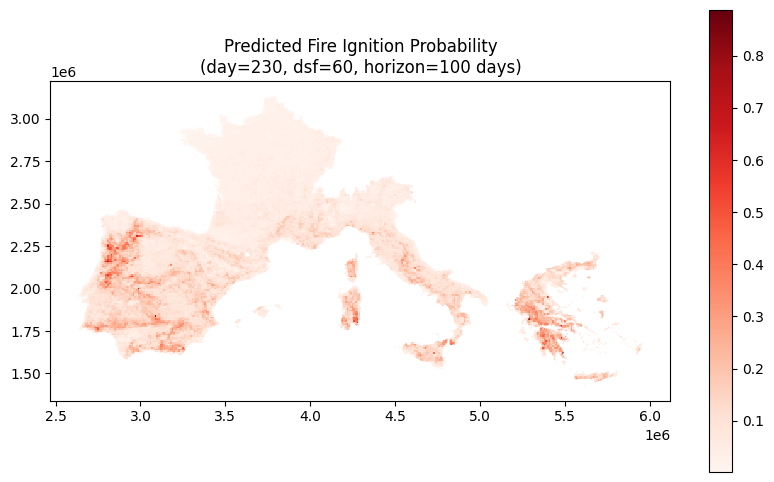

In [ ]:
# gdf["centroid_x"] = gdf.geometry.centroid.x
# gdf["centroid_y"] = gdf.geometry.centroid.y
# gdf["centroid"] = gdf.geometry.centroid


def create_fire_probability_map_cox(
    ensemble_models,
    event_df,
    df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
):
    import matplotlib.pyplot as plt

    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry="geometry")

    gdf = event_df.drop_duplicates(subset="id").copy()

    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]
    scaler = model_obj["scaler"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]

    features = [
        "temperatur", "drought_20", "forest_combined", "nbr_fire_risk", "nbr_forest",
        "nbr_powerline", "cos_month", "sin_month", "temp_sq", "days_since_last_fire",
        "mean_elev", "slope30", "humidity", "pline_den", "agricultur", "shrubland",
        "grassland", "urban", "other", "irrigated"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "forest_combined", "days_since_last_fire",
        "nbr_fire_risk", "nbr_powerline", "nbr_forest", "humidity", "mean_elev",
        "slope30", "agricultur", "shrubland", "grassland", "urban", "other",
        "pline_den", "irrigated"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)

        stat_dict = {
            "temperatur": "q75",
            "humidity": "q25",
            "drought_20": "q25",
            "wind_speed": stat
        }
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        for f in features:
            if f not in scenario_row:
                scenario_row[f] = 0.0

        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
        X_final = X_final[features]

        surv_func = cox_model.predict_survival_function(X_final).iloc[:, 0]
        clamped_time = min(forecast_horizon, surv_func.index[-1])
        surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
        ignition_prob = 1.0 - surv_prob
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass

    return gdf
gdf_map = create_fire_probability_map_cox(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
)

fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=60, horizon=100 days)")
plt.show()


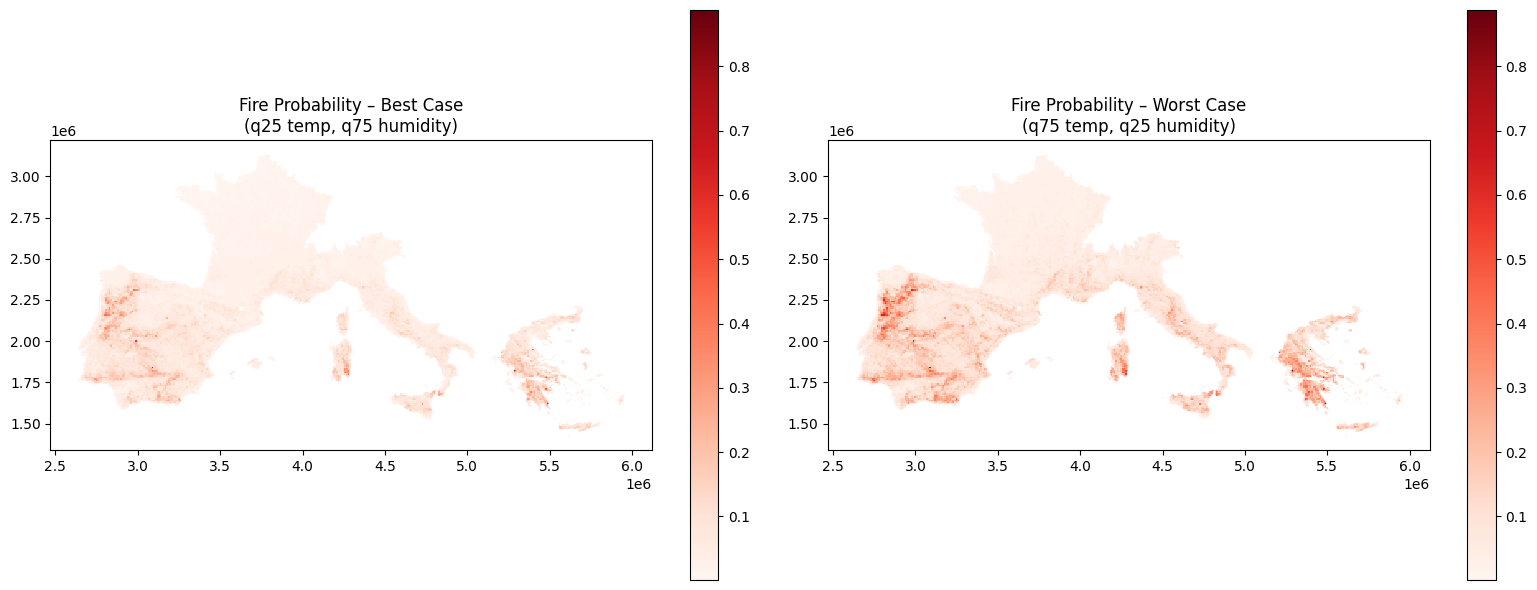

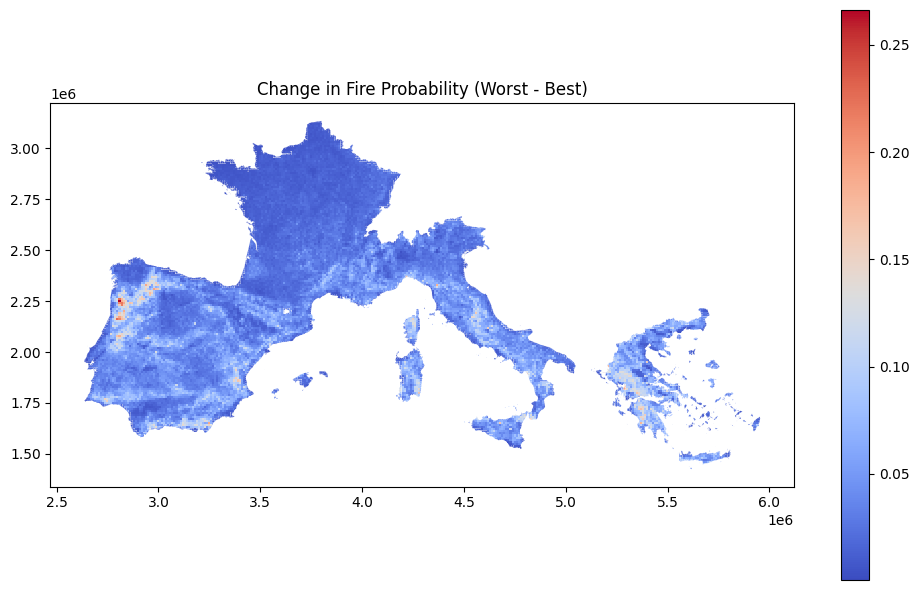

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

def create_fire_probability_map_cox(
    ensemble_models,
    event_df,
    df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=None,
    stat='median',
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry="geometry")

    gdf = event_df.drop_duplicates(subset="id").copy()

    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]
    scaler = model_obj["scaler"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]

    features = [
        "temperatur", "drought_20", "forest_combined", "nbr_fire_risk", "nbr_forest",
        "nbr_powerline", "cos_month", "sin_month", "temp_sq", "days_since_last_fire",
        "mean_elev", "slope30", "humidity", "pline_den", "agricultur", "shrubland",
        "grassland", "urban", "other", "irrigated"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "forest_combined", "days_since_last_fire",
        "nbr_fire_risk", "nbr_powerline", "nbr_forest", "humidity", "mean_elev",
        "slope30", "agricultur", "shrubland", "grassland", "urban", "other",
        "pline_den", "irrigated"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]
        baseline = build_baseline_row(event_df, grid_id)

        if stat_dict is None:
            stat_dict = {
                "temperatur": "median",
                "humidity": "median",
                "drought_20": "median",
                "wind_speed": stat
            }

        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        for f in features:
            if f not in scenario_row:
                scenario_row[f] = 0.0

        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
        X_final = X_final[features]

        surv_func = cox_model.predict_survival_function(X_final).iloc[:, 0]
        clamped_time = min(forecast_horizon, surv_func.index[-1])
        surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
        ignition_prob = 1.0 - surv_prob
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs
    return gdf

# scenario-
stat_dict_best = {
    "temperatur": "q25", "humidity": "q75", "drought_20": "q75", "wind_speed": "median"
}
stat_dict_worst = {
    "temperatur": "q75", "humidity": "q25", "drought_20": "q25", "wind_speed": "median"
}

# maps
gdf_map_best = create_fire_probability_map_cox(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=stat_dict_best
)

gdf_map_worst = create_fire_probability_map_cox(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=60,
    forecast_horizon=100,
    neighbor_radius=10000,
    stat_dict=stat_dict_worst
)

# color
vmin = min(gdf_map_best["predicted_prob"].min(), gdf_map_worst["predicted_prob"].min())
vmax = max(gdf_map_best["predicted_prob"].max(), gdf_map_worst["predicted_prob"].max())



# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

gdf_map_best.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title("Fire Probability – Best Case\n(q25 temp, q75 humidity)")

gdf_map_worst.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title("Fire Probability – Worst Case\n(q75 temp, q25 humidity)")

plt.tight_layout()
plt.show()

# difference
gdf_diff = gdf_map_worst.copy()
gdf_diff["delta"] = gdf_map_worst["predicted_prob"] - gdf_map_best["predicted_prob"]

fig, ax = plt.subplots(figsize=(10, 6))
gdf_diff.plot(column="delta", cmap="coolwarm", legend=True, ax=ax)
ax.set_title("Change in Fire Probability (Worst - Best)")
plt.tight_layout()
plt.show()


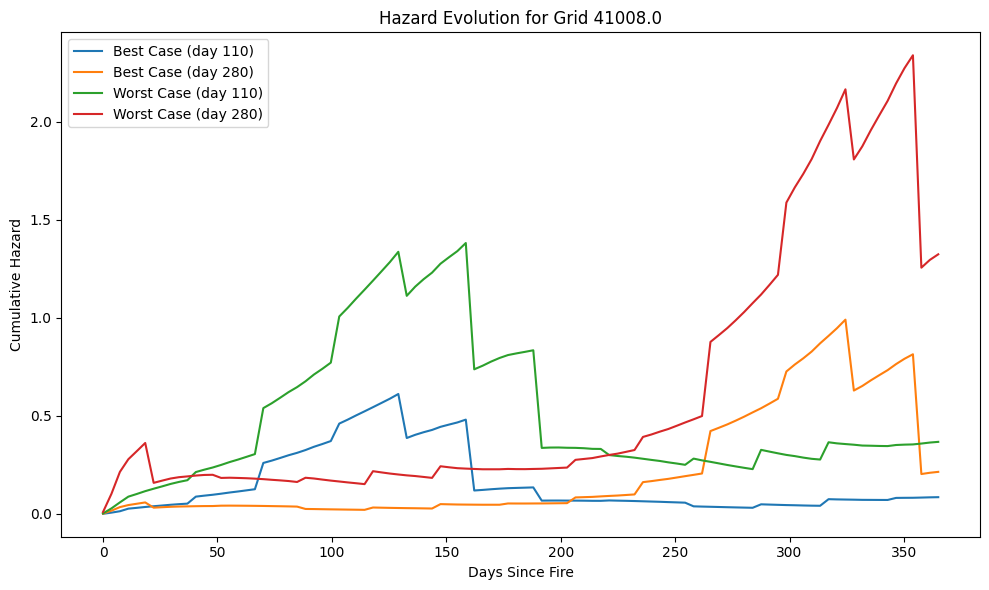

In [29]:
def compare_fire_timing_overlay_cox(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=None,
    scenario_labels=None
):
    import matplotlib.pyplot as plt
    import numpy as np

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "nbr_fire_risk", "nbr_forest",
        "nbr_powerline", "cos_month", "sin_month", "temp_sq", "days_since_last_fire",
        "mean_elev", "slope30", "humidity", "pline_den", "agricultur", "shrubland",
        "grassland", "urban", "other", "irrigated"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "forest_combined", "days_since_last_fire",
        "nbr_fire_risk", "nbr_powerline", "nbr_forest", "humidity", "mean_elev",
        "slope30", "agricultur", "shrubland", "grassland", "urban", "other",
        "pline_den", "irrigated"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    forecast_times = np.linspace(0, forecast_horizon, 100)
    model_obj = ensemble_models[0]
    cox_model = model_obj["model"]
    df_train = model_obj["df_train_raw"]
    coords_train = model_obj["coords_train"]
    tree_train = model_obj["tree_train"]
    scaler = model_obj["scaler"]

    baseline = build_baseline_row(event_df, grid_id)

    if stat_dicts is None:
        stat_dicts = [
            {"temperatur": "q25", "humidity": "q75", "drought_20": "q75", "wind_speed": "median"},
            {"temperatur": "q75", "humidity": "q25", "drought_20": "q25", "wind_speed": "median"},
        ]
    if scenario_labels is None:
        scenario_labels = ["Best Case", "Worst Case"]

    plt.figure(figsize=(10, 6))

    for stat_dict, label in zip(stat_dicts, scenario_labels):
        for init_day in initial_day_values:
            hazard_curve = []
            for t in forecast_times:
                day_t = (init_day + t) % 365
                month = day_to_month(day_t)
                cos_month, sin_month = compute_seasonality_cos_sin(day_t)

                monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat_dict=stat_dict)

                row = baseline.copy()
                row.update(monthly_vars)
                row["days_since_last_fire"] = days_since_fire
                row["cos_month"] = cos_month
                row["sin_month"] = sin_month

                row = compute_neighbor_features(row, df_train, coords_train, tree_train, neighbor_radius)

                row["forest_combined"] = (row["forest"] + row["nbr_forest"]) / 2
                row["temp_sq"] = row["temperatur"] ** 2

                for feature in rsf_features:
                    if feature not in row:
                        row[feature] = 0.0

                X_temp = pd.DataFrame([row])
                X_temp_ordered = X_temp[cols_to_scale]  # enforce same order
                X_scaled = pd.DataFrame(
                    scaler.transform(X_temp_ordered), columns=cols_to_scale
                )

                X_final = pd.concat([X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1)
                X_final = X_final[rsf_features]

                surv_func = cox_model.predict_survival_function(X_final).iloc[:, 0]
                clamped_time = min(t, surv_func.index[-1])
                surv_prob = float(surv_func.loc[surv_func.index >= clamped_time].iloc[0])
                hazard = -np.log(np.clip(surv_prob, 1e-6, 1.0))
                hazard_curve.append(hazard)

            plt.plot(forecast_times, hazard_curve, label=f"{label} (day {init_day})")

    plt.xlabel("Days Since Fire")
    plt.ylabel("Cumulative Hazard")
    plt.title(f"Hazard Evolution for Grid {grid_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()
compare_fire_timing_overlay_cox(
    ensemble_models=ensemble_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=41008.0,
    initial_day_values=[110, 280],
    forecast_horizon=365,
    days_since_fire=0,
    neighbor_radius=5000,
    stat_dicts=[
        {"temperatur": "q25", "humidity": "q75", "drought_20": "q75"},
        {"temperatur": "q75", "humidity": "q25", "drought_20": "q25"}
    ],
    scenario_labels=["Best Case", "Worst Case"]
)


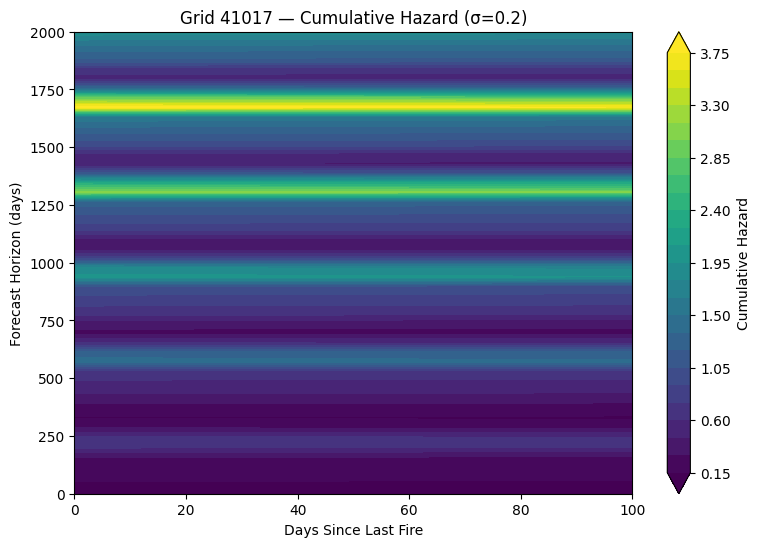

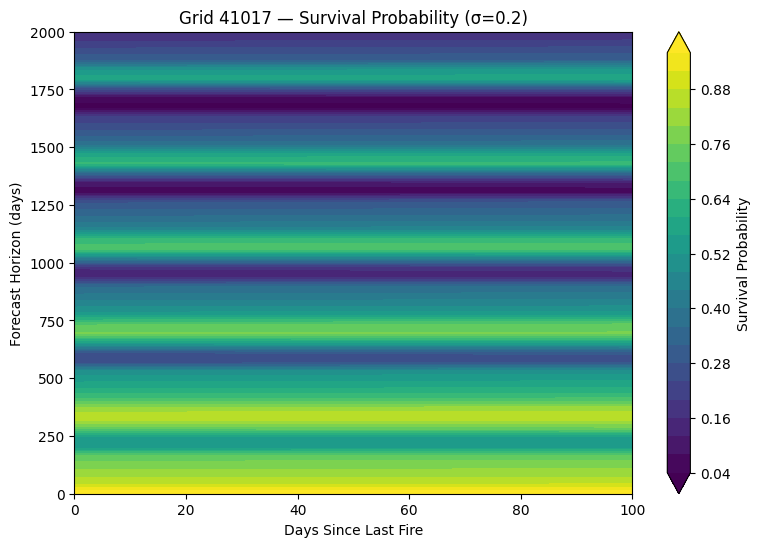

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# CONTOUR PLOT FUNCTION FOR CUMULATIVE HAZARD & SURVIVAL
static_nbr_features = compute_static_neighbor_features(df_tr_raw, coords_train, tree_train, radius=10000)
def eval_sf_lifelines(sf_df, t):
    """Safely evaluates survival probability at time `t` from a lifelines survival function DataFrame."""
    if t <= sf_df.index[0]:
        return 1.0
    elif t >= sf_df.index[-1]:
        return sf_df.iloc[-1, 0]
    else:
        return sf_df.loc[sf_df.index <= t].iloc[-1, 0]


def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
):
    # ranges
    days_since_fire_range = np.arange(0, 101, 5)
    # Baseline survival times union
    # all_times = np.unique(np.concatenate([
    #     em['model'].baseline_survival_.index.values
    #     for em in ensemble_models
    # ]))
    forecast_range = np.linspace(0, 2000, 50)


    # initialize matrices
    n_f = len(forecast_range)
    n_d = len(days_since_fire_range)
    survival_matrix = np.zeros((n_f, n_d))
    hazard_matrix   = np.zeros((n_f, n_d))

    # predictor & scaling cols
    predictor_vars = [
        'temperatur','wind_speed','drought_20','forest_combined','nbr_fire_risk',
        'nbr_forest','nbr_powerline','cos_month','sin_month','no_prior_fire',
        'temp_sq','days_since_last_fire','mean_elev','slope30','humidity',
        'pline_den','agricultur','shrubland','grassland','urban','other'
    ]
    cols_to_scale = [
        'temperatur','wind_speed','drought_20','forest_combined','days_since_last_fire',
        'nbr_fire_risk','nbr_powerline','nbr_forest','humidity','mean_elev','slope30',
        'agricultur','shrubland','grassland','urban','other','pline_den'
    ]

    # 4) Loop grid
    for i, t in enumerate(forecast_range):
        month = int((t % 365) // 30) + 1
        monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

        for j, dsf in enumerate(days_since_fire_range):
            # baseline row
            row = build_baseline_row(event_df, grid_id)
            row['days_since_last_fire'] = dsf
            c, s = compute_seasonality_cos_sin(t)
            row['cos_month'], row['sin_month'] = c, s
            row.update(monthly)

            # static required
            for var in ['pline_den','grassland','shrubland','agricultur',
                        'slope30','mean_elev','no_prior_fire','urban','other']:
                row[var] = row.get(var, 0.0)

            # ensemble predictions
            survs = []
            for em in ensemble_models:
                r = row.copy()
                nbrs = static_nbr_features.get(grid_id, {
                    "nbr_fire_risk": 0.0,
                    "nbr_forest": 0.0,
                    "nbr_road": 0.0,
                    "nbr_powerline": 0.0
                })
                r.update(nbrs)

                r["forest_combined"] = (r["forest"] + r["nbr_forest"]) / 2  # If nbr_forest is still computed
                r["temp_sq"] = r["temperatur"]**2
                
                X = pd.DataFrame([r])
                X_scaled = X.copy()
                
                X_scaled[cols_to_scale] = em['scaler'].transform(X[cols_to_scale])
                
                Xf = X_scaled[predictor_vars]

                sf_df = em["model"].predict_survival_function(Xf)  # lifelines returns a DataFrame
                survs.append(eval_sf_lifelines(sf_df, t))


            avg_surv = np.mean(survs)
            survival_matrix[i,j] = avg_surv
            hazard_matrix[i,j]   = -np.log(avg_surv) if avg_surv>0 else np.nan
            # if i == 48 and j == 5:
            #     print(pd.Series(r))

    # 5) Smooth
    surv_sm = gaussian_filter(survival_matrix, sigma=sigma)
    haz_sm  = gaussian_filter(hazard_matrix,   sigma=sigma)

    # 6) Meshgrid
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    # 7) Contour plots
    plt.figure(figsize=(9,6))
    cf = plt.contourf(Xg, Yg, haz_sm, levels=30, extend='both')
    plt.colorbar(cf, label='Cumulative Hazard')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} — Cumulative Hazard (σ={sigma})')
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

    plt.figure(figsize=(9,6))
    cf2 = plt.contourf(Xg, Yg, surv_sm, levels=30, extend='both')
    plt.colorbar(cf2, label='Survival Probability')
    plt.xlabel('Days Since Last Fire')
    plt.ylabel('Forecast Horizon (days)')
    plt.title(f'Grid {grid_id} — Survival Probability (σ={sigma})')
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

# ─── Example Usage ───────────────────────────────────────────────────────────
grid_id = int(41017)

predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_models,
    event_df=gdf,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
)


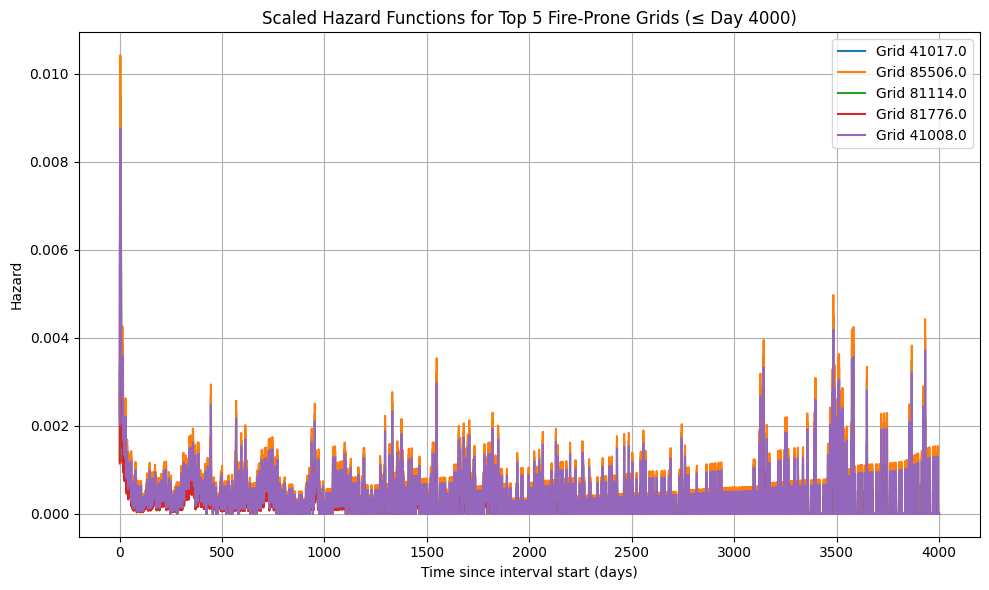

In [123]:
# Step 1: Identify the top 5 most fire-prone grids
top_grids = (
    gdf.groupby("id")["fire_occur"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

# Step 2: Prepare clipped baseline hazard
safe_time_limit = 4000
baseline_haz = cph.baseline_hazard_
haz_times = baseline_haz.index
h0_raw = baseline_haz["baseline hazard"]

# Clip to stable range
haz_mask = haz_times <= safe_time_limit
h0 = h0_raw[haz_mask]
haz_times = haz_times[haz_mask]

# Step 3: Plot scaled hazard for each top grid
plt.figure(figsize=(10, 6))
static_features = compute_static_neighbor_features(df_tr_raw, coords_train, tree_train, radius=10000)

for gid in top_grids:
    row = build_baseline_row(gdf, gid)
    month = 6  # e.g., June
    monthly_vals = get_monthly_values(df_monthly, gid, month)
    row.update(monthly_vals)

    # Seasonality
    c, s = compute_seasonality_cos_sin(30 * (month - 1) + 15)
    row["cos_month"], row["sin_month"] = c, s

    # Neighbor features
    nbrs = static_features.get(gid, {
        "nbr_fire_risk": 0.0, "nbr_forest": 0.0, "nbr_road": 0.0, "nbr_powerline": 0.0
    })
    row.update(nbrs)

    # Derived and missing
    row["forest_combined"] = (row["forest"] + row["nbr_forest"]) / 2
    row["temp_sq"] = row["temperatur"]**2
    for var in ["pline_den", "grassland", "shrubland", "agricultur", "slope30", "mean_elev", "no_prior_fire", "urban", "other"]:
        row[var] = row.get(var, 0.0)

    # Prepare input
    X = pd.DataFrame([row])
    X_scaled = X.copy()
    X_scaled[to_scale] = scaler.transform(X[to_scale])
    x_beta = cph.predict_partial_hazard(X_scaled[features]).values[0]

    # Scaled hazard (clipped)
    scaled_hazard = h0 * x_beta
    plt.plot(haz_times, scaled_hazard, label=f"Grid {gid}")

# Step 4: Final plot
plt.title("Scaled Hazard Functions for Top 5 Fire-Prone Grids (≤ Day 4000)")
plt.xlabel("Time since interval start (days)")
plt.ylabel("Hazard")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
spike_window = (gdf["stop_time"] >= 3540) & (gdf["stop_time"] <= 3670)
focus_ids = [41231.0, 41008.0]
spike_df = gdf[spike_window & gdf["id"].isin(focus_ids)].copy()
print(spike_df.groupby("id")["fire_occur"].agg(["count", "sum"]))



         count  sum
id                 
41008.0      3    2
41231.0      4    2


In [57]:
important_vars = [
    "id", "start_time", "stop_time", "fire_occur",
    "temperatur", "drought_20", "humidity", "wind_speed",
    "days_since_last_fire", "no_prior_fire",
    "cos_month", "sin_month"
]

# Only show rows with fire or close to fire
spike_df_sorted = spike_df[important_vars].sort_values(["id", "start_time"])

# Optional: highlight rows where fire_occur == 1
print(spike_df_sorted.to_string(index=False))


     id  start_time  stop_time  fire_occur  temperatur  drought_20  humidity  wind_speed  days_since_last_fire  no_prior_fire  cos_month  sin_month
41008.0      3538.0       3575           1   26.437408    0.000313 24.208296   14.417834                    70              0   0.500000  -0.866025
41008.0      3575.0       3606           0   13.463335    0.037138 41.009254    2.926506                    31              0   0.866025  -0.500000
41008.0      3606.0       3612           1   16.755149    0.037139 40.125862    5.750484                    37              0   0.866025  -0.500000
41231.0      3530.0       3568           1   26.444750    0.004964 14.874681    4.540365                    49              0   0.500000  -0.866025
41231.0      3568.0       3570           0   26.102151    0.003198 18.095491    1.616551                     2              0   0.500000  -0.866025
41231.0      3570.0       3572           1   26.067727    0.001565 22.080988    5.195640                     4  

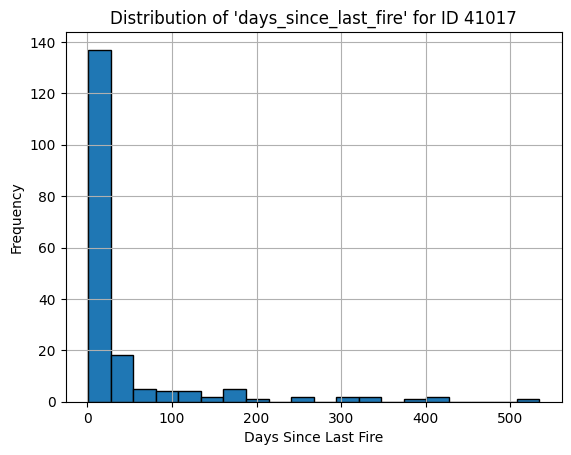

In [31]:
filtered_df = event_df[event_df['id'] == 41017]

# Check distribution using a histogram
plt.hist(filtered_df['days_since_last_fire'], bins=20, edgecolor='black')
plt.title("Distribution of 'days_since_last_fire' for ID 41017")
plt.xlabel("Days Since Last Fire")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [25]:
import gc
del ensemble_models, model_package, haz_times, scaled_hazard
gc.collect()

17208

In [26]:
import psutil

mem = psutil.virtual_memory()
print(f"System: {mem.used/1e9:.1f} GB used / {mem.total/1e9:.1f} GB total")

p = psutil.Process()  # your own Python process
print(f"Process: {p.memory_info().rss/1e9:.2f} GB resident")


System: 13.5 GB used / 16.5 GB total
Process: 0.43 GB resident


## RSF model

In [22]:
print(event_df.crs)


None


In [10]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from sklearn.preprocessing import MinMaxScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# Prepare GeoDataFrame
gdf = df_split.copy()
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"] = gdf.geometry.centroid

# Fix 0-duration events
eps = 0.5
mask_zero = (gdf["fire_occur"] == 1) & (gdf["stop_time"] == gdf["start_time"])
gdf.loc[mask_zero, "stop_time"] += eps
gdf["duration"] = gdf["stop_time"] - gdf["start_time"]

# Select features
model_vars = [
    "fire_occur", "id", "start_time", "stop_time", "duration",
    "temperatur", "drought_20", "forest", "road_den", "pline_den",
    "grassland", "shrubland", "agricultur", "days_since_last_fire",
    "mean_elev", "no_prior_fire", "cos_month", "sin_month",
    "slope30", "humidity", "urban", "other", "centroid_x", "centroid_y", "irrigated"
]
df_model = gdf[model_vars].select_dtypes(include=[np.number]).copy()

# ─── Temporal Split ─────────────────────────────────────────────
threshold_days = 4479
df_tr = df_model[df_model["stop_time"] <= threshold_days].copy()
df_te = df_model[df_model["stop_time"] > threshold_days].copy()

# ─── Neighbor Features ─────────────────────────────────────────
coords_tr = df_tr[["centroid_x", "centroid_y"]].values
coords_te = df_te[["centroid_x", "centroid_y"]].values
tree = cKDTree(coords_tr)
R = 10000
lag_days = 10
nbr_cols = ["nbr_fire_risk", "nbr_forest", "nbr_road", "nbr_powerline"]

for D in [df_tr, df_te]:
    for c in nbr_cols:
        D[c] = np.nan

for i, pt in enumerate(coords_tr):
    my_start = df_tr.iloc[i]["start_time"]
    all_nb = tree.query_ball_point(pt, R)
    past_nb = [j for j in all_nb if df_tr.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_tr.iloc[past_nb]
    dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_tr.at[df_tr.index[i], "nbr_fire_risk"]  = sub["fire_occur"].sum() / sub["duration"].sum()
    df_tr.at[df_tr.index[i], "nbr_forest"]     = np.average(sub["forest"], weights=w)
    df_tr.at[df_tr.index[i], "nbr_road"]       = np.average(sub["road_den"], weights=w)
    df_tr.at[df_tr.index[i], "nbr_powerline"]  = np.average(sub["pline_den"], weights=w)
# compute on TEST (only using TRAIN history)
coords_tr = df_tr[["centroid_x","centroid_y"]].values
for i, pt in enumerate(df_te[["centroid_x","centroid_y"]].values):
    my_start = df_te.iloc[i]["start_time"]
    all_nb = tree.query_ball_point(pt, R)
    past_nb = [j for j in all_nb if df_tr.iloc[j]["stop_time"] < (my_start - lag_days)]

    if not past_nb:
        continue
    sub = df_tr.iloc[past_nb]
    dists = np.linalg.norm(coords_tr[past_nb] - pt, axis=1) + 1e-6
    w = 1.0 / dists
    df_te.at[df_te.index[i], "nbr_fire_risk"]  = sub["fire_occur"].sum() / sub["duration"].sum()
    df_te.at[df_te.index[i], "nbr_forest"]     = np.average(sub["forest"], weights=w)
    df_te.at[df_te.index[i], "nbr_road"]       = np.average(sub["road_den"], weights=w)
    df_te.at[df_te.index[i], "nbr_powerline"]  = np.average(sub["pline_den"], weights=w)
# Fill & derive features
nbr_cols = ["nbr_forest","nbr_road","nbr_powerline"]
for df in [df_tr, df_te]:
    df[nbr_cols] = df[nbr_cols].fillna(df_tr[nbr_cols].median())
    df["nbr_fire_risk"] = df["nbr_fire_risk"].fillna(0.0)
for df in (df_tr, df_te):
    df["forest_combined"] = (df["forest"] + df["nbr_forest"]) / 2
    df["temp_sq"] = df["temperatur"] ** 2

# ─── 3.5) ZERO‐IMPUTE ANY REMAINING NaNs ────────────────────────────────────
fill_zero_cols = [
    "forest_combined",
    "agricultur",
    "shrubland",
    "grassland",
    "urban",
    "other",
    "irrigated"
]
for D in (df_tr, df_te):
    # this will overwrite any NaN with 0
    D[fill_zero_cols] = D[fill_zero_cols].fillna(0)

# ─── Scaling ───────────────────────────────────────────────────
scale_cols = [
    "temperatur", "drought_20", "pline_den", "forest",
    "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "nbr_forest", "humidity", "mean_elev", "slope30",
    "agricultur", "shrubland", "grassland", "urban", "other", "irrigated"
]
df_train_raw = df_tr.copy()
scaler = MinMaxScaler()
df_tr[scale_cols] = scaler.fit_transform(df_tr[scale_cols])
df_te[scale_cols] = scaler.transform(df_te[scale_cols])

df_tr["fire_occur"] = df_tr["fire_occur"].astype(bool)
df_te["fire_occur"] = df_te["fire_occur"].astype(bool)

# ─── Fit RSF ───────────────────────────────────────────────────
rsf_features = [
    "temperatur", "drought_20", "forest", "grassland", "shrubland",
    "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "cos_month", "temp_sq", "mean_elev", 
    "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month", "irrigated"
]

y_train = Surv.from_arrays(event=df_tr["fire_occur"], time=df_tr["duration"])
y_test = Surv.from_arrays(event=df_te["fire_occur"], time=df_te["duration"])
X_train = df_tr[rsf_features]
X_test = df_te[rsf_features]

w = np.ones(len(df_tr))

# Halve the weight for any “first‐ever” interval
# w[df_tr["no_prior_fire"] == 1] *= 0.3

# And also halve the weight for any 1‑day‑since‑last‑fire interval
w[df_tr["days_since_last_fire"] == 1] *= 0.4

rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=30, min_samples_leaf=40,
                           max_features=0.1, n_jobs=1, random_state=42)
rsf.fit(X_train, y_train)

train_pred = rsf.predict(X_train)
test_pred = rsf.predict(X_test)

c_idx_train = concordance_index_censored(y_train["event"], y_train["time"], train_pred)[0]
c_idx_test = concordance_index_censored(y_test["event"], y_test["time"], test_pred)[0]

print(f"\nTrain C-index: {c_idx_train:.4f}")
print(f"Test  C-index:  {c_idx_test:.4f}")

# Save model package
ensemble_rsf_models = [{
    "model": rsf,
    "scaler": scaler,
    "df_train_raw": df_train_raw,
    "df_train": df_tr,
    "coords_train": coords_tr,
    "tree_train": tree
}]



Train C-index: 0.9370
Test  C-index:  0.8897


In [125]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

def c_index_scorer(estimator, X, y):
    preds = estimator.predict(X)
    return concordance_index_censored(y["event"], y["time"], preds)[0]

def batched_permutation_importance(
    model, X, y,
    batch_size=2000,
    n_batches=50,
    random_state=None
):
    rng = np.random.RandomState(random_state)
    feat_names = X.columns
    all_means = np.zeros((n_batches, len(feat_names)))
    all_stds  = np.zeros((n_batches, len(feat_names)))

    for i in range(n_batches):
        # 1) sample a random batch of indices without replacement
        print(i)
        idx = rng.choice(len(X), size=batch_size, replace=False)
        X_batch = X.iloc[idx]
        y_batch = y[idx]

        # 2) single‐repeat permutation importance on that batch
        res = permutation_importance(
            model,
            X_batch,
            y_batch,
            scoring=c_index_scorer,
            n_repeats=1,       # we’ll average over many batches
            random_state=rng
        )
        all_means[i, :] = res.importances_mean
        all_stds[i, :]  = res.importances_std

    # 3) aggregate across batches
    perm_imp = pd.DataFrame({
        "feature": feat_names,
        "importance_mean": all_means.mean(axis=0),
        "importance_std" : all_means.std(axis=0, ddof=1),
        "batch_std_mean": all_stds.mean(axis=0)
    }).sort_values("importance_mean", ascending=False).reset_index(drop=True)

    return perm_imp

# --- Usage ---
perm_imp = batched_permutation_importance(
    rsf, X_test, y_test,
    batch_size=2000,
    n_batches=10,
    random_state=42
)
print(perm_imp)


0
1
2
3
4
5
6
7
8
9
                 feature  importance_mean  importance_std  batch_std_mean
0          nbr_fire_risk         0.028216        0.002590             0.0
1   days_since_last_fire         0.019913        0.003306             0.0
2               humidity         0.017628        0.004035             0.0
3                slope30         0.004941        0.001060             0.0
4             agricultur         0.003289        0.000993             0.0
5             temperatur         0.002956        0.001565             0.0
6              cos_month         0.002510        0.001549             0.0
7                temp_sq         0.001993        0.001499             0.0
8             nbr_forest         0.001837        0.000905             0.0
9              grassland         0.001664        0.000564             0.0
10             shrubland         0.001481        0.000674             0.0
11         nbr_powerline         0.001203        0.000909             0.0
12                

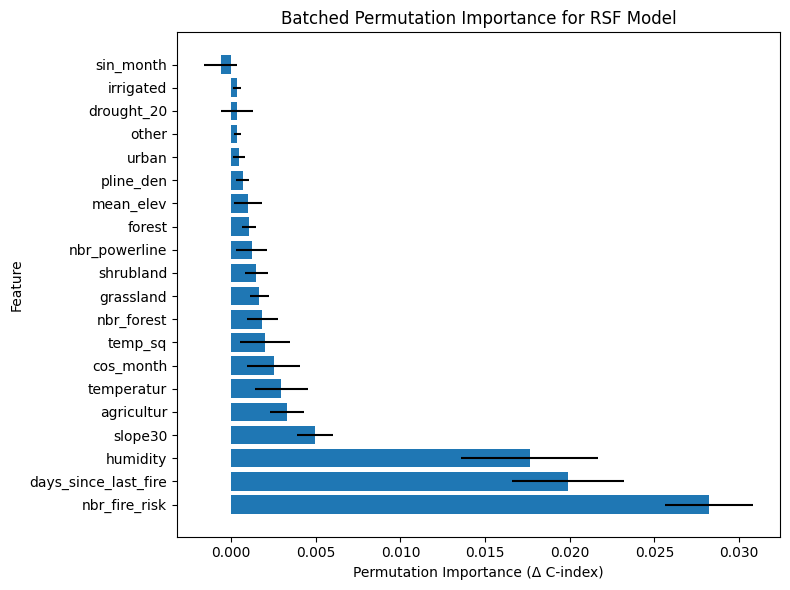

In [126]:
import matplotlib.pyplot as plt

# perm_imp should already live in your namespace
features = perm_imp['feature']
means    = perm_imp['importance_mean']
stds     = perm_imp['importance_std']

plt.figure(figsize=(8, 6))
plt.barh(features, means, xerr=stds)
plt.xlabel("Permutation Importance (Δ C-index)")
plt.ylabel("Feature")
plt.title("Batched Permutation Importance for RSF Model")
plt.tight_layout()
plt.show()


RSF Integrated Brier Score: 0.0658 ± 0.0007
RSF Integrated Brier Score (mean curve): 0.0658


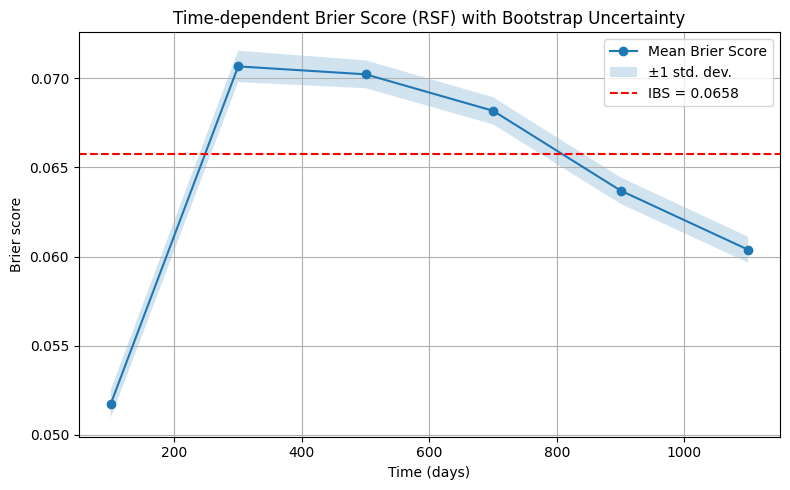

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score
from sksurv.util import Surv

# --- 1) Structured arrays for sksurv ---
y_train_struct = Surv.from_arrays(event=df_tr["fire_occur"], time=df_tr["duration"])
y_test_struct  = Surv.from_arrays(event=df_te["fire_occur"], time=df_te["duration"])

# --- 2) Evaluation times (inside observed window) ---
eval_times = np.arange(100, 1300, 200)

# --- 3) Get full-test survival matrix (n_samples × n_times) ---
# This returns a list of step‐function objects, one per sample
sf_list = rsf.predict_survival_function(X_test)
# Build an array: for each sample i, for each time t_j, sf_list[i](t_j)
sf_full = np.vstack([
    np.interp(eval_times, fn.x, fn.y) 
    for fn in sf_list
])  # shape (n_samples, n_times)

# --- 4) Bootstrap Brier curves on the test set ---
n_bootstraps = 200
n_test       = len(df_te)
n_times      = len(eval_times)
all_bs       = np.zeros((n_bootstraps, n_times))
idxs         = np.arange(n_test)

for b in range(n_bootstraps):
    boot_idx = np.random.choice(idxs, size=n_test, replace=True)
    y_test_b = y_test_struct[boot_idx]
    sf_b     = sf_full[boot_idx, :]  # (n_test, n_times)

    _, bs_curve = brier_score(
        y_train_struct,
        y_test_b,
        sf_b,
        eval_times
    )
    all_bs[b] = bs_curve

# --- 5) Compute mean and std, and Integrated Brier Score ---
mean_bs = all_bs.mean(axis=0)
std_bs  = all_bs.std(axis=0)
ibs     = np.trapezoid(mean_bs, eval_times) / (eval_times[-1] - eval_times[0])
ibs_boot = np.array([
    np.trapezoid(bs_curve, eval_times) / (eval_times[-1] - eval_times[0])
    for bs_curve in all_bs
])

# 2) Mean and sample‐std of the bootstrap IBS
ibs_mean = ibs_boot.mean()
ibs_std  = ibs_boot.std(ddof=1)   # ddof=1 for sample‐std

print(f"RSF Integrated Brier Score: {ibs_mean:.4f} ± {ibs_std:.4f}")

print(f"RSF Integrated Brier Score (mean curve): {ibs:.4f}")

# --- 6) Plot with ±1 std dev band ---
plt.figure(figsize=(8,5))
plt.plot(eval_times, mean_bs, marker="o", label="Mean Brier Score")
plt.fill_between(eval_times,
                 mean_bs - std_bs,
                 mean_bs + std_bs,
                 alpha=0.2,
                 label="±1 std. dev.")
plt.axhline(ibs, color="red", linestyle="--", label=f"IBS = {ibs:.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Brier score")
plt.title("Time-dependent Brier Score (RSF) with Bootstrap Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


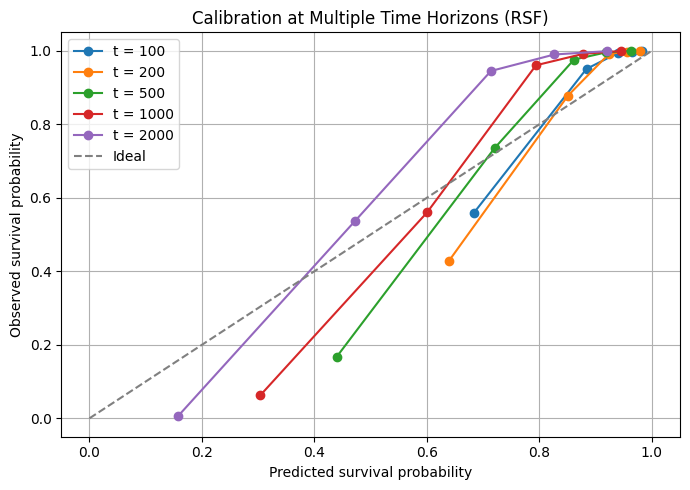

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Choose time horizons and number of bins
time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

calibration_data = []

for t in time_horizons:
    # 2. Predict survival at time t for each test sample
    # rsf.predict_survival_function returns a list of step‐functions, one per sample
    surv_funcs = rsf.predict_survival_function(X_test)
    pred_surv = np.array([
        np.interp(t, fn.x, fn.y)    # interpolate each step‐function at t
        for fn in surv_funcs
    ])
    
    # 3. Attach predictions and bin into quantiles
    df_te["pred_surv_prob"] = pred_surv
    df_te["risk_group"]     = pd.qcut(pred_surv, q=n_bins, labels=False, duplicates="drop")
    
    # 4. For each bin, compute mean predicted & observed via KM
    kmf = KaplanMeierFitter()
    for group in range(df_te["risk_group"].nunique()):
        sub = df_te[df_te["risk_group"] == group]
        if len(sub) < 5:
            continue
        mean_pred = sub["pred_surv_prob"].mean()
        kmf.fit(sub["duration"], sub["fire_occur"])
        obs_surv = kmf.predict(t)
        calibration_data.append({
            "time": t,
            "pred": mean_pred,
            "obs":  obs_surv
        })

# 5. Plot
df_cal = pd.DataFrame(calibration_data)

plt.figure(figsize=(7, 5))
for t in sorted(df_cal["time"].unique()):
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (RSF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


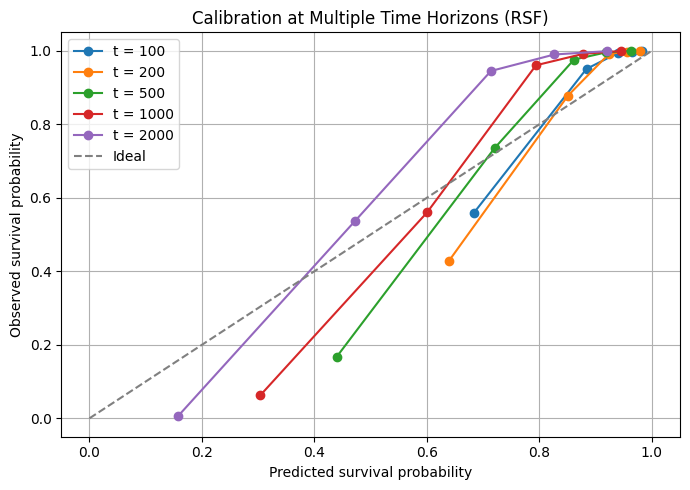

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Choose time horizons and number of bins
time_horizons = [100, 200, 500, 1000, 2000]
n_bins = 5

calibration_data = []

for t in time_horizons:
    # 2. Predict survival at time t for each test sample
    # rsf.predict_survival_function returns a list of step‐functions, one per sample
    surv_funcs = rsf.predict_survival_function(X_test)
    pred_surv = np.array([
        np.interp(t, fn.x, fn.y)    # interpolate each step‐function at t
        for fn in surv_funcs
    ])
    
    # 3. Attach predictions and bin into quantiles
    df_te["pred_surv_prob"] = pred_surv
    df_te["risk_group"]     = pd.qcut(pred_surv, q=n_bins, labels=False, duplicates="drop")
    
    # 4. For each bin, compute mean predicted & observed via KM
    kmf = KaplanMeierFitter()
    for group in range(df_te["risk_group"].nunique()):
        sub = df_te[df_te["risk_group"] == group]
        if len(sub) < 5:
            continue
        mean_pred = sub["pred_surv_prob"].mean()
        kmf.fit(sub["duration"], sub["fire_occur"])
        obs_surv = kmf.predict(t)
        calibration_data.append({
            "time": t,
            "pred": mean_pred,
            "obs":  obs_surv
        })

# 5. Plot
df_cal = pd.DataFrame(calibration_data)

plt.figure(figsize=(7, 5))
for t in sorted(df_cal["time"].unique()):
    sub = df_cal[df_cal["time"] == t]
    plt.plot(sub["pred"], sub["obs"], marker="o", label=f"t = {t}")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Ideal")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival probability")
plt.title("Calibration at Multiple Time Horizons (RSF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


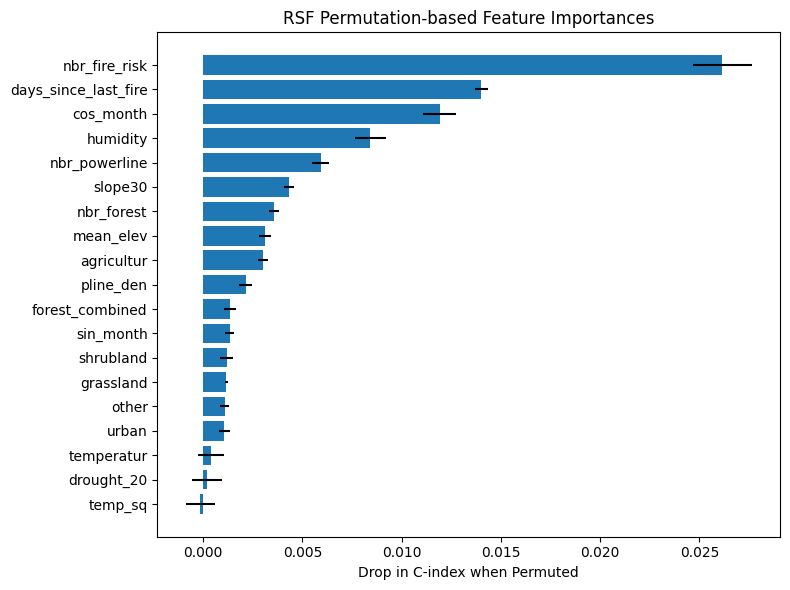

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored



# 2) Permutation importance (slower but more reliable)
def cindex_scorer(model, X, y):
    pred = model.predict(X)
    return concordance_index_censored(y["event"], y["time"], pred)[0]

from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rsf,
    X_test,
    y_test,
    scoring=cindex_scorer,
    n_repeats=5,
    random_state=0,
    n_jobs=2,
    max_samples=5000     # <= sample 5 000 rows internally
)

imp_mean = perm.importances_mean
imp_std  = perm.importances_std
idx_perm = np.argsort(imp_mean)[::-1]

plt.figure(figsize=(8,6))
plt.barh(np.array(rsf_features)[idx_perm][::-1],
         imp_mean[idx_perm][::-1],
         xerr=imp_std[idx_perm][::-1])
plt.title("RSF Permutation‐based Feature Importances")
plt.xlabel("Drop in C‑index when Permuted")
plt.tight_layout()
plt.show()


Integrated Brier Score (IBS): 0.0734


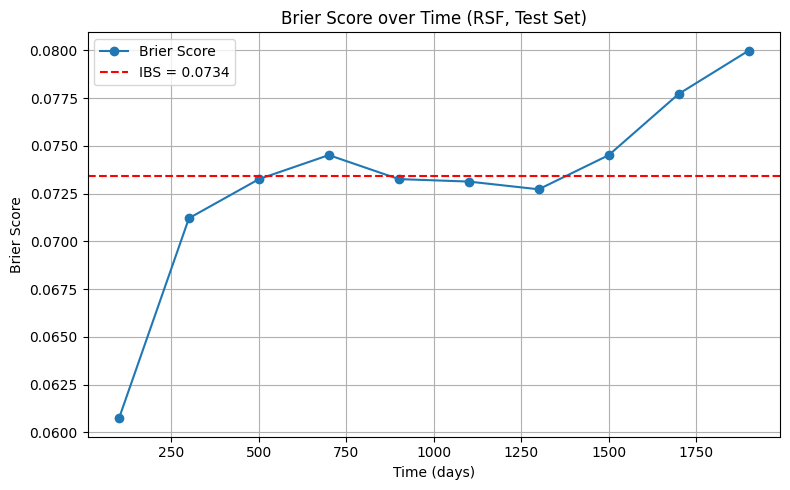

In [14]:
from sksurv.metrics import brier_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Define evaluation times (fewer points reduces memory usage)
eval_times = np.arange(100, 2000, 200)

# 2. Predict survival function in batches
def get_sf_at_times(model, X, times, batch_size=1000):
    results = []
    for i in range(0, len(X), batch_size):
        X_batch = X.iloc[i:i+batch_size]
        sf_list = model.predict_survival_function(X_batch)
        sf_batch = np.asarray([
            [sf(t) if t <= sf.x[-1] else sf.y[-1] for t in times]
            for sf in sf_list
        ])
        results.append(sf_batch)
    return np.vstack(results)

# 3. Run prediction and compute Brier score
sf_array = get_sf_at_times(rsf, X_test, eval_times)

# Compute time-dependent Brier scores
times, bs = brier_score(y_train, y_test, sf_array, eval_times)

# 4. Compute Integrated Brier Score (IBS)
ibs = np.trapezoid(bs, times) / (times[-1] - times[0])
print(f"Integrated Brier Score (IBS): {ibs:.4f}")

# 5. Plot Brier score over time
plt.figure(figsize=(8, 5))
plt.plot(times, bs, marker="o", label="Brier Score")
plt.axhline(ibs, color="red", linestyle="--", label=f"IBS = {ibs:.4f}")
plt.title("Brier Score over Time (RSF, Test Set)")
plt.xlabel("Time (days)")
plt.ylabel("Brier Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
print(event_df.crs)


EPSG:3035


In [74]:
y_train

array([(False,  178.), (False,  381.), ( True, 3551.), ...,
       (False, 3755.), (False,  962.), (False, 2838.)],
      dtype=[('event', '?'), ('time', '<f8')])

Survival range: 0.44858135362065815 → 0.999263810007332
Hazard   range: 0.0007364611135931617 → 0.8016652234739997


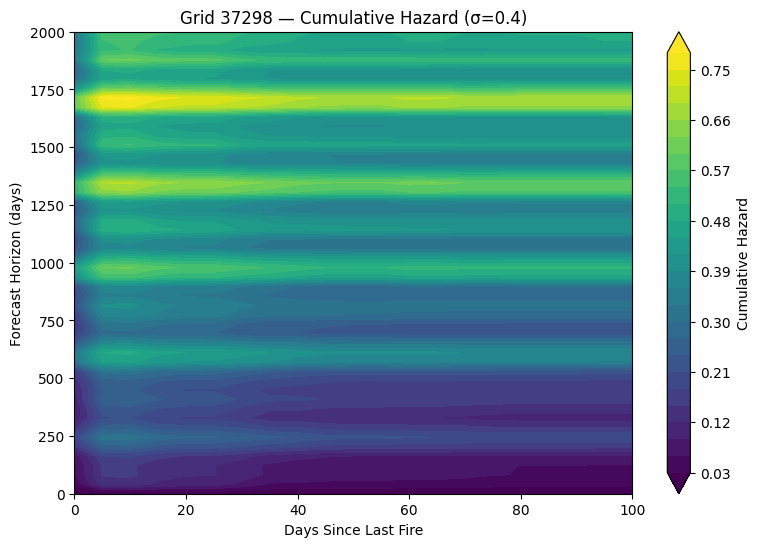

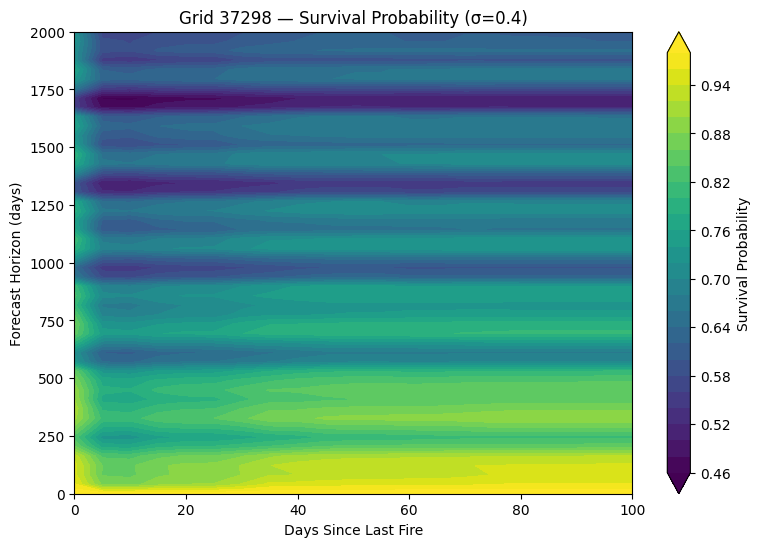

In [16]:
# mediterranian plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def eval_sf_at(sf, t):
    t_max = sf.x[-1]
    if t <= t_max:
        return sf(t)
    else:
        return sf.y[-1]
def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
):
    # 1) Ranges
    days_since_fire_range = np.arange(0, 101, 5)

    # Build forecast_range as union of every model's unique_times_ support
    starts = [mdl["model"].unique_times_[0]  for mdl in ensemble_models]
    ends   = [mdl["model"].unique_times_[-1] for mdl in ensemble_models]
    t_min  = max(starts)
    t_max  = min(ends)
    forecast_range = np.linspace(0, 2000, 50)
    

    # 2) Prepare storage
    n_f = len(forecast_range)
    n_d = len(days_since_fire_range)
    survival_matrix = np.zeros((n_f, n_d))
    hazard_matrix   = np.zeros((n_f, n_d))

    # 3) Model features
    predictor_vars = [
    "temperatur", "drought_20", "forest", "grassland", "shrubland",
    "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "cos_month", "temp_sq", "mean_elev", 
    "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month", "irrigated"
    ]
    cols_to_scale = [
    "temperatur", "drought_20", "pline_den", "forest",
    "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "nbr_forest", "humidity", "mean_elev", "slope30",
    "agricultur", "shrubland", "grassland", "urban", "other", "irrigated"
    ]

    # 4) Loop through grid of (forecast_time, days_since_fire)
    for i, t in enumerate(forecast_range):
        month = day_to_month(t % 365)
        monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

        for j, dsf in enumerate(days_since_fire_range):
            # Baseline row
            row = build_baseline_row(event_df, grid_id)
            row["days_since_last_fire"] = dsf
            c, s = compute_seasonality_cos_sin(t)
            row["cos_month"], row["sin_month"] = c, s
            row.update(monthly)

            # Ensure required static fields
            for var in ["pline_den","grassland","shrubland","agricultur",
                        "slope30","mean_elev","urban","other"]:
                row[var] = row.get(var, 0.0)

            # Predict for each fold
            survs = []
            for mdl in ensemble_models:
                rm = compute_neighbor_features(
                    row.copy(),
                    mdl["df_train_raw"],
                    mdl["coords_train"],
                    mdl["tree_train"],
                    neighbor_radius
                )
                rm["forest_combined"] = (rm["forest"] + rm["nbr_forest"]) / 2
                rm["road_combined"]   = (rm["road_den"] + rm["nbr_road"]) / 2

                X = pd.DataFrame([rm])
                Xs = X.copy()
                Xs[cols_to_scale] = mdl["scaler"].transform(X[cols_to_scale])
                Xs["temp_sq"] = Xs["temperatur"] ** 2

                Xf = Xs[predictor_vars]
                # get the list of survival‐function objects
                sf_list = mdl["model"].predict_survival_function(Xf)

                # evaluate the first one at your forecast time t
                sf = sf_list[0]
                surv_at_t = eval_sf_at(sf, t)

                survs.append(surv_at_t)


            avg = np.mean(survs)
            survival_matrix[i, j] = avg
            hazard_matrix[i, j]   = -np.log(avg) if avg > 0 else np.nan

    # 5) Debug ranges
    print("Survival range:", np.nanmin(survival_matrix), "→", np.nanmax(survival_matrix))
    print("Hazard   range:", np.nanmin(hazard_matrix),   "→", np.nanmax(hazard_matrix))

    # 6) Smooth
    surv_sm = gaussian_filter(survival_matrix, sigma=sigma)
    haz_sm  = gaussian_filter(hazard_matrix,   sigma=sigma)

    # 7) Plot
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(9,6))
    cf = plt.contourf(Xg, Yg, haz_sm, levels=30, extend="both")
    plt.colorbar(cf, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Cumulative Hazard (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

    plt.figure(figsize=(9,6))
    cf2 = plt.contourf(Xg, Yg, surv_sm, levels=30, extend="both")
    plt.colorbar(cf2, label="Survival Probability")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Survival Probability (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()


# Example usage:
grid_id = int(37298.0)
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"]    = gdf.geometry.centroid

event_df = gdf.copy()

predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.4
)
# RSF signals can be noisy so we need to have higher sigma


Survival range: 0.19547584628167627 → 0.9999252237557347
Hazard   range: 7.477904014805996e-05 → 1.6323184556207762


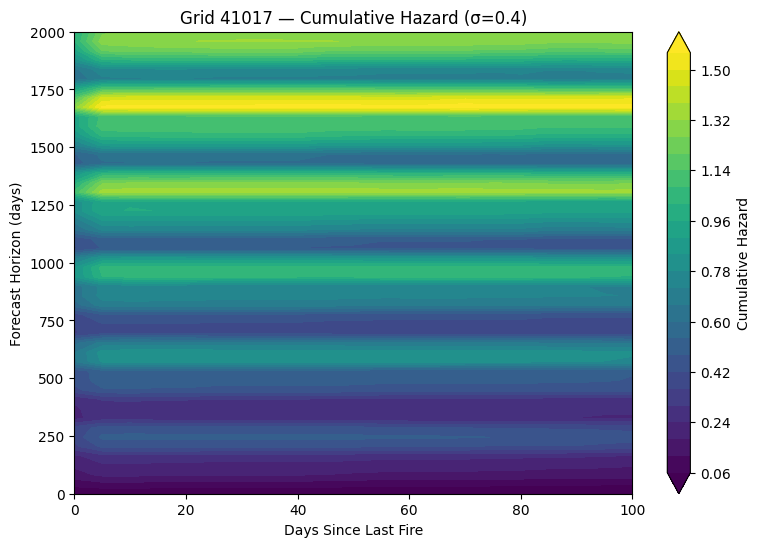

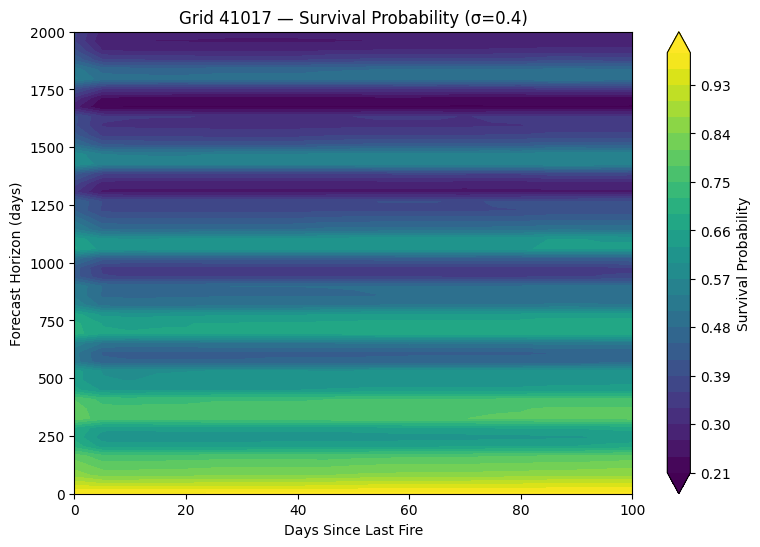

In [16]:
# mediterranian plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
def eval_sf_at(sf, t):
    t_max = sf.x[-1]
    if t <= t_max:
        return sf(t)
    else:
        return sf.y[-1]
def predict_and_plot_with_AG_ensemble(
    ensemble_models,
    event_df,
    df_monthly,
    grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.2
):
    # 1) Ranges
    days_since_fire_range = np.arange(0, 101, 5)

    # Build forecast_range as union of every model's unique_times_ support
    starts = [mdl["model"].unique_times_[0]  for mdl in ensemble_models]
    ends   = [mdl["model"].unique_times_[-1] for mdl in ensemble_models]
    t_min  = max(starts)
    t_max  = min(ends)
    forecast_range = np.linspace(0, 2000, 50)
    

    # 2) Prepare storage
    n_f = len(forecast_range)
    n_d = len(days_since_fire_range)
    survival_matrix = np.zeros((n_f, n_d))
    hazard_matrix   = np.zeros((n_f, n_d))

    # 3) Model features
    predictor_vars = [
    "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
    "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
    "cos_month", "temp_sq", "mean_elev", 
    "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other"
    ]

    # 4) Loop through grid of (forecast_time, days_since_fire)
    for i, t in enumerate(forecast_range):
        month = day_to_month(t % 365)
        monthly = get_monthly_values(df_monthly, grid_id, month, stat=statistic)

        for j, dsf in enumerate(days_since_fire_range):
            # Baseline row
            row = build_baseline_row(event_df, grid_id)
            row["days_since_last_fire"] = dsf
            c, s = compute_seasonality_cos_sin(t)
            row["cos_month"], row["sin_month"] = c, s
            row.update(monthly)

            # Ensure required static fields
            for var in ["pline_den","grassland","shrubland","agricultur",
                        "slope30","mean_elev","urban","other"]:
                row[var] = row.get(var, 0.0)

            # Predict for each fold
            survs = []
            for mdl in ensemble_models:
                rm = compute_neighbor_features(
                    row.copy(),
                    mdl["df_train_raw"],
                    mdl["coords_train"],
                    mdl["tree_train"],
                    neighbor_radius
                )
                rm["forest_combined"] = (rm["forest"] + rm["nbr_forest"]) / 2
                rm["road_combined"]   = (rm["road_den"] + rm["nbr_road"]) / 2

                X = pd.DataFrame([rm])
                Xs = X.copy()
                Xs[cols_to_scale] = mdl["scaler"].transform(X[cols_to_scale])
                Xs["temp_sq"] = Xs["temperatur"] ** 2

                Xf = Xs[predictor_vars]
                # get the list of survival‐function objects
                sf_list = mdl["model"].predict_survival_function(Xf)

                # evaluate the first one at your forecast time t
                sf = sf_list[0]
                surv_at_t = eval_sf_at(sf, t)

                survs.append(surv_at_t)


            avg = np.mean(survs)
            survival_matrix[i, j] = avg
            hazard_matrix[i, j]   = -np.log(avg) if avg > 0 else np.nan

    # 5) Debug ranges
    print("Survival range:", np.nanmin(survival_matrix), "→", np.nanmax(survival_matrix))
    print("Hazard   range:", np.nanmin(hazard_matrix),   "→", np.nanmax(hazard_matrix))

    # 6) Smooth
    surv_sm = gaussian_filter(survival_matrix, sigma=sigma)
    haz_sm  = gaussian_filter(hazard_matrix,   sigma=sigma)

    # 7) Plot
    Xg, Yg = np.meshgrid(days_since_fire_range, forecast_range)

    plt.figure(figsize=(9,6))
    cf = plt.contourf(Xg, Yg, haz_sm, levels=30, extend="both")
    plt.colorbar(cf, label="Cumulative Hazard")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Cumulative Hazard (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()

    plt.figure(figsize=(9,6))
    cf2 = plt.contourf(Xg, Yg, surv_sm, levels=30, extend="both")
    plt.colorbar(cf2, label="Survival Probability")
    plt.xlabel("Days Since Last Fire")
    plt.ylabel("Forecast Horizon (days)")
    plt.title(f"Grid {grid_id} — Survival Probability (σ={sigma})")
    plt.xlim(0, 100)
    plt.ylim(forecast_range.min(), forecast_range.max())
    plt.show()


# Example usage:
grid_id = int(41017.0)
gdf["centroid_x"] = gdf.geometry.centroid.x
gdf["centroid_y"] = gdf.geometry.centroid.y
gdf["centroid"]    = gdf.geometry.centroid

event_df = gdf.copy()

predict_and_plot_with_AG_ensemble(
    ensemble_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    grid_id=grid_id,
    statistic='median',
    neighbor_radius=10000,
    sigma=0.4
)
# RSF signals can be noisy so we need to have higher sigma


In [19]:
n_unique_ids = event_df.loc[event_df["fire_occur"] == 1, "id"].nunique()
print("Number of unique ids that experienced at least one fire:", n_unique_ids)


Number of unique ids that experienced at least one fire: 4704


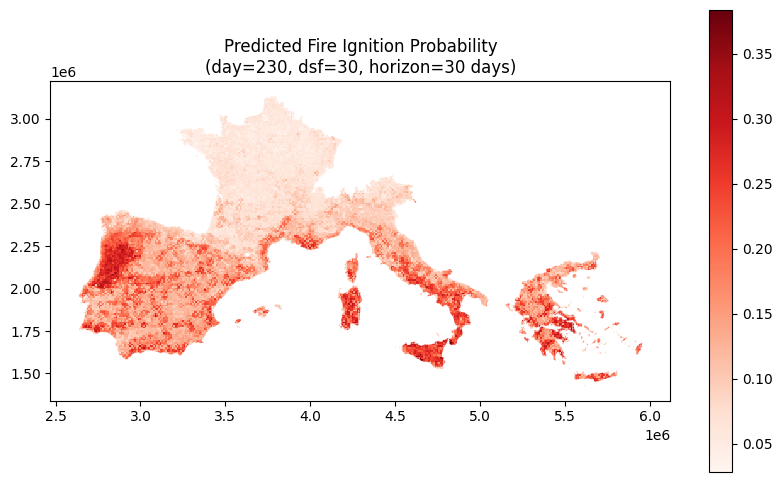

In [ ]:
def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest_combined", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month", "irrigated"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest_combined",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other", "irrigated"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat)
        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=30, horizon=30 days)")
plt.show()

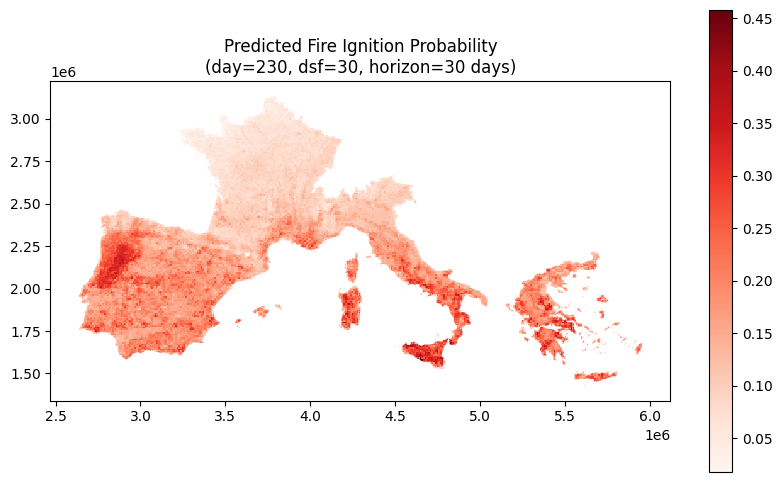

In [ ]:
# model efter opdateret split
event_df = gpd.GeoDataFrame(event_df, geometry="geometry")
event_df["centroid"]    = event_df.geometry.centroid
event_df["centroid_x"]  = event_df.centroid.x
event_df["centroid_y"]  = event_df.centroid.y
def create_fire_probability_map(
    ensemble_rsf_models,
    event_df,
    df_monthly, 
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
):
    if not isinstance(event_df, gpd.GeoDataFrame):
        event_df = gpd.GeoDataFrame(event_df, geometry='geometry')

    gdf = event_df.drop_duplicates(subset='id').copy()

    first_model = ensemble_rsf_models[0]
    scaler = first_model["scaler"]
    df_train = first_model["df_train"]
    coords_train = first_model["coords_train"]
    tree_train = first_model["tree_train"]

    rsf_features = [
        "temperatur", "drought_20", "forest", "grassland", "shrubland",
        "agricultur", "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "cos_month", "temp_sq", "mean_elev", 
        "nbr_forest", "pline_den", "slope30", "humidity", "urban", "other", "sin_month", "irrigated"
    ]
    cols_to_scale = [
        "temperatur", "drought_20", "pline_den", "forest",
        "days_since_last_fire", "nbr_fire_risk", "nbr_powerline",
        "nbr_forest", "humidity", "mean_elev", "slope30",
        "agricultur", "shrubland", "grassland", "urban", "other", "irrigated"
    ]
    derived_features = ["cos_month", "sin_month", "temp_sq"]

    month = day_to_month(day_of_year)
    cos_month, sin_month = compute_seasonality_cos_sin(day_of_year)

    predicted_probs = []

    for _, row in gdf.iterrows():
        grid_id = row["id"]

        baseline = build_baseline_row(event_df, grid_id)
        monthly_vars = get_monthly_values(df_monthly, grid_id, month, stat)
        scenario_row = baseline.copy()
        scenario_row.update(monthly_vars)
        scenario_row["days_since_last_fire"] = days_since_fire
        scenario_row["cos_month"] = cos_month
        scenario_row["sin_month"] = sin_month

        scenario_row = compute_neighbor_features(
            scenario_row, df_train, coords_train, tree_train, neighbor_radius
        )

        # Derived features
        scenario_row["forest_combined"] = (scenario_row["forest"] + scenario_row["nbr_forest"]) / 2
        scenario_row["temp_sq"] = scenario_row["temperatur"] ** 2

        # Scale + transform
        X_temp = pd.DataFrame([scenario_row])
        X_scaled = pd.DataFrame(
            scaler.transform(X_temp[cols_to_scale]), columns=cols_to_scale
        )
        X_final = pd.concat(
            [X_scaled, X_temp[derived_features].reset_index(drop=True)], axis=1
        )
        X_final = X_final[rsf_features]

        surv_probs = [
            m["model"].predict_survival_function(X_final)[0](forecast_horizon)
            for m in ensemble_rsf_models
        ]
        ignition_prob = 1.0 - np.mean(surv_probs)
        predicted_probs.append(ignition_prob)

    gdf["predicted_prob"] = predicted_probs

    if sigma > 0:
        pass  # optional smoothing step

    return gdf


gdf_map = create_fire_probability_map(
    ensemble_rsf_models=ensemble_rsf_models,
    event_df=event_df,
    df_monthly=df_monthly,
    day_of_year=230,
    days_since_fire=30,
    forecast_horizon=30,
    neighbor_radius=10000,
    stat='median',
    sigma=0.0
)
fig, ax = plt.subplots(figsize=(10, 6))
gdf_map.plot(column="predicted_prob", cmap="Reds", legend=True, ax=ax)
ax.set_title("Predicted Fire Ignition Probability\n(day=230, dsf=30, horizon=30 days)")
plt.show()

In [18]:
import numpy as np
from scipy.stats import shapiro, ttest_1samp, wilcoxon
from sksurv.metrics import concordance_index_censored

# --- 1) Precompute risk “scores” on your TEST set ---
# assume `cph` is your fitted CoxPHFitter, `rsf` your fitted RandomSurvivalForest
# and df_te is your test‐split DataFrame, df_te[features] are the covariates used.

# 1a) CoxPH: partial hazard
cox_scores = cph.predict_partial_hazard(df_te[features]).values

# 1b) RSF: risk score
rsf_scores = rsf.predict(df_te[rsf_features].reset_index(drop=True))

# survival‐format ground truth
events    = df_te["fire_occur"].astype(bool).values
durations = df_te["duration"].values

n_obs = len(durations)

# --- 2) Bootstrap ΔC = C_rsf − C_cox over n_boot resamples ---
n_boot = 1000
delta  = np.empty(n_boot)
rng    = np.random.default_rng(42)

for i in range(n_boot):
    idx = rng.integers(0, n_obs, n_obs)
    e   = events   [idx]
    t   = durations[idx]
    c_cox = concordance_index_censored(e, t, cox_scores[idx])[0]
    c_rsf = concordance_index_censored(e, t, rsf_scores[idx])[0]
    delta[i] = c_rsf - c_cox
    # if 3 < i < 15:
    #     print("sample", i, 
    #         "Cox[0..4] =", concordance_index_censored(e[:5], t[:5], cox_scores[idx][:5])[0],
    #         "RSF[0..4] =", concordance_index_censored(e[:5], t[:5], rsf_scores[idx][:5])[0])


# --- 3) Summarize bootstrap distribution ---
mean_delta = delta.mean()
ci_low, ci_high = np.percentile(delta, [2.5, 97.5])
print(f"RSF – CoxPH: ΔC = {mean_delta:.3f}, 95% CI = [{ci_low:.3f}, {ci_high:.3f}]")

# --- 4) Statistical tests on the bootstrap Δ’s ---
W_sw, p_sw = shapiro(delta)
t_stat, p_t  = ttest_1samp(delta, 0.0)
w_stat, p_w  = wilcoxon(delta)

print(f"Shapiro–Wilk: W = {W_sw:.3f}, p = {p_sw:.3f}")
print(f"One‐sample t‐test: t = {t_stat:.3f}, p = {p_t:.4f}")
print(f"Wilcoxon signed‐rank: W = {w_stat:.1f}, p = {p_w:.4f}")


RSF – CoxPH: ΔC = 0.027, 95% CI = [0.026, 0.029]
Shapiro–Wilk: W = 0.999, p = 0.853
One‐sample t‐test: t = 921.884, p = 0.0000
Wilcoxon signed‐rank: W = 0.0, p = 0.0000


## DeepSurv